In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import datetime
pd.set_option('display.max_columns', None)

In [2]:
current_directory = os.getcwd()
print(current_directory)

C:\Users\lalep\OneDrive - Queen's University\Documents\Queens University\MMAI 823 - AI in Finance\Final Project\MMAI-823-Final-Project\Amir


In [3]:
data = pd.read_csv('output.csv')

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [5]:
# Find the minimum and maximum values of the "timestamp" column
min_timestamp = data['timestamp'].min()
max_timestamp = data['timestamp'].max()

# Print the results
print("Minimum Timestamp:", min_timestamp)
print("Maximum Timestamp:", max_timestamp)

Minimum Timestamp: 2021-01-28 09:08:16
Maximum Timestamp: 2021-08-16 09:26:20


In [6]:
df_sorted_sentiment = data.sort_values('timestamp')
df_sorted_sentiment.head()

,score,id,comms_num,timestamp,text,original_text,Weekday,negative_score,positive_score,neutral_score,compound_score,overall_sentiment,text_sentiment_polarity,text_sentiment_subjectivity
257,50,l6h58v,8,2021-01-28 09:08:16,autists journeymonth storytime,An autists journey. $150 to $68k in one month....,Thursday,0.000,0.000,1.000,0.0000,Neutral,0.000000,0.000000
256,70,l6h59b,7,2021-01-28 09:08:17,melvin live,You all have made Melvin live up to its name,Thursday,0.000,0.000,1.000,0.0000,Neutral,0.136364,0.500000
255,75,l6h5a2,14,2021-01-28 09:08:18,got late gme believe cause willing lose guys a...,I got in late on GME but I believe in the caus...,Thursday,0.190,0.206,0.603,0.1779,Positive,0.030000,0.726667
254,26,l6h5am,22,2021-01-28 09:08:19,highest si float end business jan th according...,Highest SI % of Float End of Business Jan 27th...,Thursday,0.000,0.059,0.941,0.2960,Positive,0.000000,0.000000
252,0,l6h5bt,6,2021-01-28 09:08:21,discord nt talk anti bot measure admin contact...,Discord still down i can't see how to talk to ...,Thursday,0.271,0.245,0.483,0.0772,Positive,0.400000,0.800000


In [7]:
df_daily_compound = df_sorted_sentiment.groupby(pd.Grouper(key='timestamp', freq='D')).agg({'compound_score': 'mean'}).reset_index()

In [8]:
df_daily_compound['sentiment_signal'] = df_daily_compound['compound_score'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

In [9]:
df_daily_compound.set_index('timestamp', inplace=True)
df_daily_compound.head(100)

,compound_score,sentiment_signal
timestamp,,
2021-01-28,0.029089,1
2021-01-29,-0.018890,-1
2021-01-30,0.137982,1
2021-01-31,0.145259,1
2021-02-01,0.143150,1
...,...,...
2021-05-03,NaN,0
2021-05-04,NaN,0
2021-05-05,0.342417,1


In [10]:
stockList = ["GME", "AMC"]

In [11]:
sent_startDate = "2021-01-28"
sent_endDate = "2021-08-16"

startDate = "2020-01-01"
endDate = "2021-12-31"

In [12]:
df = yf.download(stockList, start=startDate, end=endDate)

[*********************100%***********************]  2 of 2 completed


In [13]:
df.head()

Adj Close         Close          High           Low          Open  \
                 AMC     GME   AMC     GME   AMC     GME   AMC     GME   AMC   
Date                                                                           
2020-01-02  7.414512  1.5775  7.46  1.5775  7.56  1.6175  7.23  1.5175  7.30   
2020-01-03  7.275366  1.4700  7.32  1.4700  7.60  1.5625  7.31  1.4600  7.45   
2020-01-06  7.076585  1.4625  7.12  1.4625  7.30  1.4775  7.11  1.4000  7.25   
2020-01-07  7.086524  1.3800  7.13  1.3800  7.20  1.4575  7.00  1.3600  7.11   
2020-01-08  6.579634  1.4300  6.62  1.4300  7.15  1.4625  6.61  1.3525  7.11   

                     Volume            
               GME      AMC       GME  
Date                                   
2020-01-02  1.5350  4545900  17814400  
2020-01-03  1.5525  2218000  14175600  
2020-01-06  1.4500  2903400  13579200  
2020-01-07  1.4425  3205300  20912000  
2020-01-08  1.3725  6557000  22517600

In [14]:
df['sentiment_signal'] = df_daily_compound['sentiment_signal']

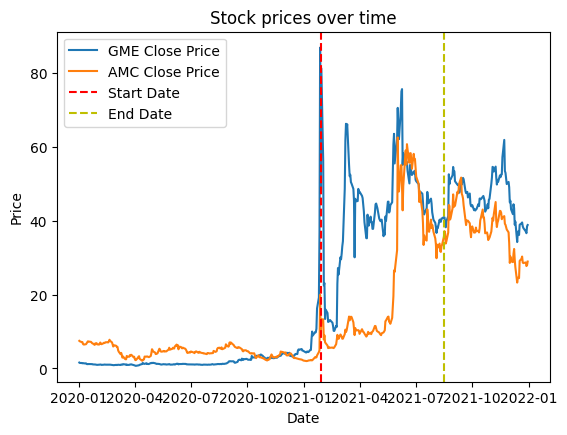

In [15]:
#Visualizing

plt.figure(figsize = (14,10))

#Line plots of stock prices over time. Note: this is actual price over that time period, which has been downloaded from Yahoo Finance

plt.subplot(2,2,1)
for symbol in stockList:
  plt.plot(df['Close'][symbol], label=f'{symbol} Close Price')

plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')

plt.title("Stock prices over time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

### Actual Returns of the 2 stocks

In [16]:
actual_returns = df["Close"].iloc[-1]/df["Close"].iloc[0] - 1

print("Actual Returns:")

for symbol, return_value in actual_returns.items():

  print(f"{symbol}: {return_value:.2%}")

Actual Returns:
AMC: 287.94%
GME: 2361.65%


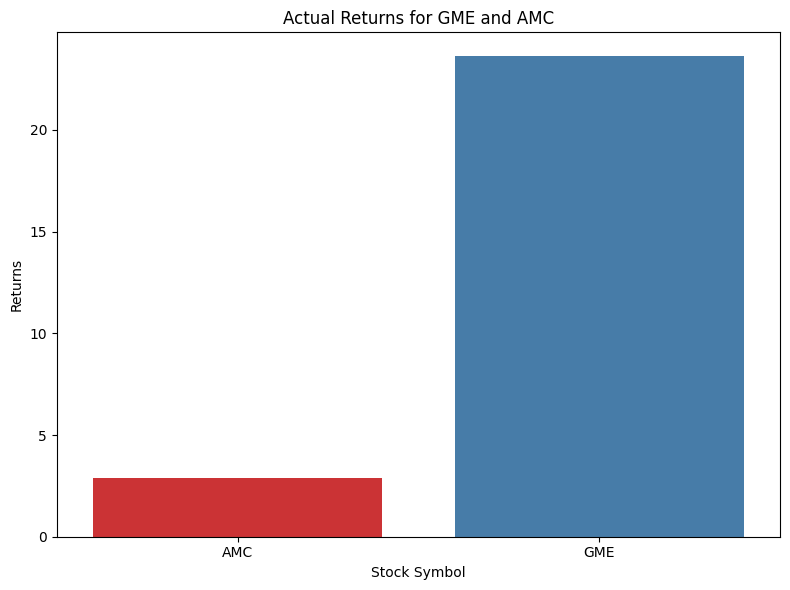

In [17]:
# Create a bar plot for actual returns
plt.figure(figsize=(8, 6))
sns.barplot(x=actual_returns.index, y=actual_returns.values, palette='Set1')
plt.title('Actual Returns for GME and AMC')
plt.ylabel('Returns')
plt.xlabel('Stock Symbol')
plt.xticks(ticks=np.arange(len(actual_returns)), labels=actual_returns.index)
plt.tight_layout()
plt.show()

# Trading Strategies

### Earning Calculation Approaches

#### **First Approach:** The earnings for each stock is calculated by taking the final cash minus the initial investment.
The percentage gain is calculated based on these earnings.
Goal: This approach simply calculates the net earnings at the end of the entire data series for each symbol after applying the price momentum strategy. It considers the earnings as the difference between the final cash on hand and the initial investment.

**Process:**

Initialize cash to initial_investment for each symbol.

For each day in the data series:

- If there's a positive price momentum and we're not already in a position, buy the stock using all available cash.

- If there's a negative price momentum and we're currently holding the stock, sell all of the stock and update the cash.

- At the end of the data series, if we're still holding the stock, sell it and add the value to cash.

- Calculate earnings as the difference between final cash and initial_investment.

#### **Second Approach:** the Ending Portfolio Value (EPV) is calculated by summing the cash on hand and the value of any stock holdings.
The percentage gain is then calculated based on this EPV.

**Process:**

Initialize cash_momentum to initial_investment for each symbol.
For each day in the data series:

- If there's a positive price momentum and we're not already in a position, buy the stock using all available cash_momentum.
- If there's a negative price momentum and we're currently holding the stock, sell all of the stock and update cash_momentum.
- At the end of the data series, if we're still holding the stock, liquidate it and add its value to cash_momentum.
- Calculate the ending portfolio value (epv_momentum) for the symbol which is equal to cash_momentum.
- Calculate the percentage gain for the symbol based on the epv_momentum.

**First Approach:**

Gives you a direct idea of the net profit or loss from the strategy.
More intuitive for a simple "how much did I make?" question.

**Second Approach:**

Provides a holistic view of the portfolio's value, including both cash and stock holdings.
Useful for understanding the total value of assets at a given time.

## Price Momentum Strategy (PM):

The price momentum strategy is a type of trading strategy that capitalizes on the observed tendency of assets to continue moving in the same direction as their recent price trends. In other words, the strategy assumes that stocks that have recently shown strong positive price movements will continue to rise, and stocks that have recently exhibited weak price movements will continue to decline.

Step 1: Fetching historical data for these two stocks has been completed

Step 2: Calculating Momentum: The goal is to calculate the price momentum as the percentage change in the stock;s closing price over specified period (e.g.: 3 months):

In [18]:
momentum_period = 90
for symbol in stockList:
    df['Momentum', symbol] = df['Close', symbol].pct_change(momentum_period)


In [19]:
# Defining the moving average period
sma_period = 10  # Example: 10-day moving average. Adjust this based on your preferences.

thresholds = {}

for symbol in stockList:
    # Calculate the moving average of the momentum
    df['Smoothed_Momentum', symbol] = df['Momentum', symbol].rolling(window=sma_period).mean()

In [20]:
momentum_period = 90
buy_threshold_AMC = df['Smoothed_Momentum', 'AMC'].quantile(0.75)
sell_threshold_AMC = df['Smoothed_Momentum', 'AMC'].quantile(0.25)

buy_threshold_GME = df['Smoothed_Momentum', 'GME'].quantile(0.75)
sell_threshold_GME = df['Smoothed_Momentum', 'GME'].quantile(0.25)

# Initialize signals as 0
df[('PM_Signal', 'AMC')] = 0
df[('PM_Signal', 'GME')] = 0

# Iterate over rows to generate signals
for i, row in df.iterrows():
    # For AMC
    if row['Smoothed_Momentum', 'AMC'] > buy_threshold_AMC:
        df.at[i, ('PM_Signal', 'AMC')] = 1
    elif row['Smoothed_Momentum', 'AMC'] < sell_threshold_AMC:
        df.at[i, ('PM_Signal', 'AMC')] = -1

    # For GME
    if row['Smoothed_Momentum', 'GME'] > buy_threshold_GME:
        df.at[i, ('PM_Signal', 'GME')] = 1
    elif row['Smoothed_Momentum', 'GME'] < sell_threshold_GME:
        df.at[i, ('PM_Signal', 'GME')] = -1

# Implement Price Momentum Trading logic
capital = 100000
position = {symbol: 0 for symbol in stockList}
shares_owned = {symbol: 0 for symbol in stockList}

for i in range(1, len(df)):
    for symbol in stockList:
        momentum_signal = df.iloc[i][('PM_Signal', symbol)]
        close_price = df.iloc[i][('Close', symbol)]
        
        # Check for buy signal
        if momentum_signal == 1 and position[symbol] == 0:
            shares_to_buy = capital // (2 * close_price)  # assuming equal distribution of capital
            shares_owned[symbol] += shares_to_buy
            capital -= shares_to_buy * close_price
            position[symbol] = 1
        
        # Check for sell signal
        elif momentum_signal == -1 and position[symbol] == 0:
            shares_to_sell_short = capital // (2 * close_price)
            shares_owned[symbol] -= shares_to_sell_short
            capital += shares_to_sell_short * close_price
            position[symbol] = -1
        
        # Check for neutral signal or closing positions
        elif momentum_signal == 0:
            if position[symbol] == 1:
                capital += shares_owned[symbol] * close_price
                shares_owned[symbol] = 0
            elif position[symbol] == -1:
                capital -= shares_owned[symbol] * close_price
                shares_owned[symbol] = 0
            position[symbol] = 0

# Price Momentum Strategy: PM
# Calculate strategy returns
for symbol in stockList:
    df['PM_Strategy_Returns', symbol] = df['PM_Signal', symbol].shift(1) * df['Close', symbol].pct_change()
    df['PM_Cumulative_Strategy_Returns', symbol] = (1 + df['PM_Strategy_Returns', symbol]).cumprod()



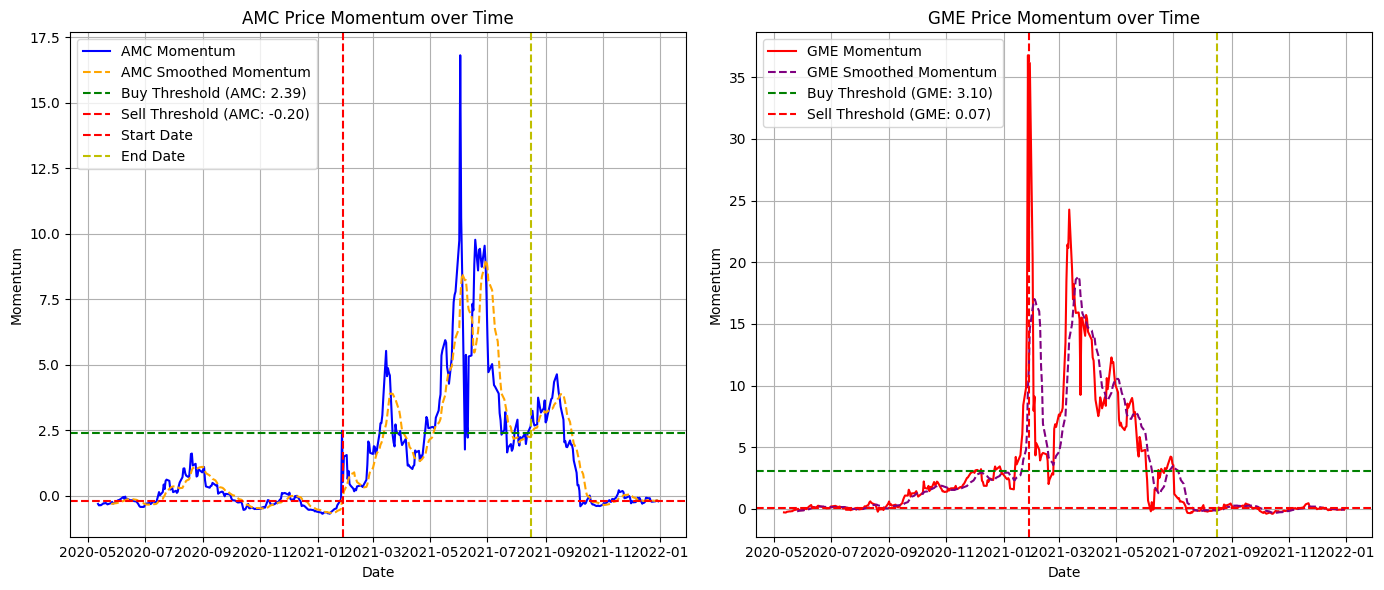

In [21]:
plt.figure(figsize=(14, 6))

# Plotting the momentum and smoothed momentum for AMC
plt.subplot(1, 2, 1)
plt.plot(df.index, df['Momentum', 'AMC'], label='AMC Momentum', color='blue')
plt.plot(df.index, df['Smoothed_Momentum', 'AMC'], label='AMC Smoothed Momentum', color='orange', linestyle='--')
plt.axhline(y=buy_threshold_AMC, color='g', linestyle='--', label=f'Buy Threshold (AMC: {buy_threshold_AMC:.2f})')
plt.axhline(y=sell_threshold_AMC, color='r', linestyle='--', label=f'Sell Threshold (AMC: {sell_threshold_AMC:.2f})')
plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
plt.title('AMC Price Momentum over Time')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True)

# Plotting the momentum and smoothed momentum for GME
plt.subplot(1, 2, 2)
plt.plot(df.index, df['Momentum', 'GME'], label='GME Momentum', color='red')
plt.plot(df.index, df['Smoothed_Momentum', 'GME'], label='GME Smoothed Momentum', color='purple', linestyle='--')
plt.axhline(y=buy_threshold_GME, color='g', linestyle='--', label=f'Buy Threshold (GME: {buy_threshold_GME:.2f})')
plt.axhline(y=sell_threshold_GME, color='r', linestyle='--', label=f'Sell Threshold (GME: {sell_threshold_GME:.2f})')
plt.title('GME Price Momentum over Time')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True)

plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
plt.tight_layout()
plt.show()


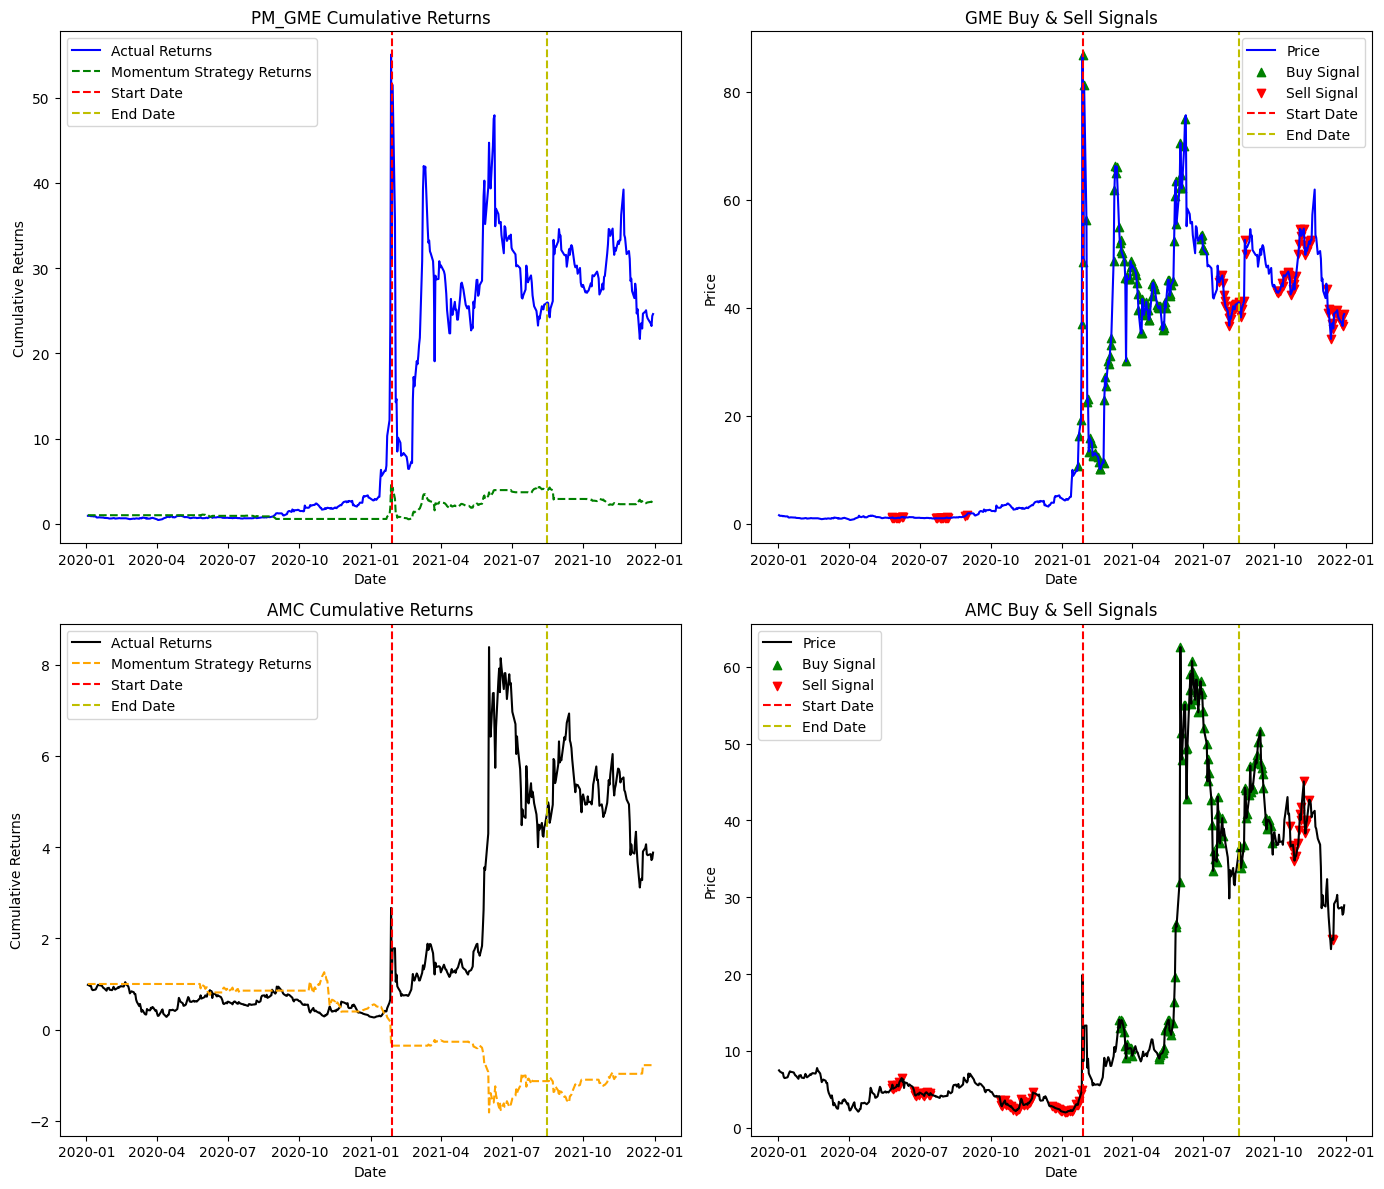

In [22]:
# Calculate the actual cumulative returns for GME and AMC for comparison
df['Cumulative_Return_GME'] = (1 + df['Close', 'GME'].pct_change()).cumprod()
df['Cumulative_Return_AMC'] = (1 + df['Close', 'AMC'].pct_change()).cumprod()

plt.figure(figsize=(14, 12))

# Plot for GME
plt.subplot(2, 2, 1)  
plt.plot(df['Cumulative_Return_GME'], label='Actual Returns', color='blue')
plt.plot(df['PM_Cumulative_Strategy_Returns', 'GME'], label='Momentum Strategy Returns', color='green', linestyle='--')
plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
plt.title('PM_GME Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Buy and Sell signals for GME
plt.subplot(2, 2, 2) 
plt.plot(df['Close', 'GME'], label='Price', color='blue')
plt.scatter(df[df['PM_Signal', 'GME'] == 1].index, df['Close', 'GME'][df['PM_Signal', 'GME'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(df[df['PM_Signal', 'GME'] == -1].index, df['Close', 'GME'][df['PM_Signal', 'GME'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)
plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
plt.title('GME Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot for AMC
plt.subplot(2, 2, 3)  
plt.plot(df['Cumulative_Return_AMC'], label='Actual Returns', color='black')
plt.plot(df['PM_Cumulative_Strategy_Returns', 'AMC'], label='Momentum Strategy Returns', color='orange', linestyle='--')
plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
plt.title('AMC Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Buy and Sell signals for AMC
plt.subplot(2, 2, 4) 
plt.plot(df['Close', 'AMC'], label='Price', color='black')
plt.scatter(df[df['PM_Signal', 'AMC'] == 1].index, df['Close', 'AMC'][df['PM_Signal', 'AMC'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(df[df['PM_Signal', 'AMC'] == -1].index, df['Close', 'AMC'][df['PM_Signal', 'AMC'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)
plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
plt.title('AMC Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
initial_investment = 1000

# Approach 1: Earnings and Percentage Gains
earnings_PM = {}
percentage_gains_PM = {}

# Approach 2: Ending Portfolio Value and Percentage Gains
epv_PM = {}
percentage_gains_PM_2 = {}

for symbol in stockList:
    # Approach 1 variables
    cash = initial_investment
    stock_quantity = 0
    in_position = False

    # Approach 2 variables
    cash_momentum = initial_investment
    stock_quantity_momentum = 0
    in_position_momentum = False
    
    for idx, row in df.iterrows():
        # Approach 1
        if row[('PM_Signal', symbol)] == 1 and not in_position:
            stock_quantity = cash / row[('Close', symbol)]
            cash = 0
            in_position = True
        elif row[('PM_Signal', symbol)] == -1 and in_position:
            cash += stock_quantity * row[('Close', symbol)]
            stock_quantity = 0
            in_position = False

        # Approach 2
        if row[('PM_Signal', symbol)] == 1 and not in_position_momentum:
            stock_quantity_momentum = cash_momentum / row[('Close', symbol)]
            cash_momentum = 0
            in_position_momentum = True
        elif row[('PM_Signal', symbol)] == -1 and in_position_momentum:
            cash_momentum += stock_quantity_momentum * row[('Close', symbol)]
            stock_quantity_momentum = 0
            in_position_momentum = False

    # Approach 1: Finalize earnings
    if in_position:
        cash += stock_quantity * df[('Close', symbol)].iloc[-1]
    earnings_PM[symbol] = cash - initial_investment
    percentage_gains_PM[symbol] = (earnings_PM[symbol] / initial_investment) * 100

    # Approach 2: Finalize portfolio value and gains
    if in_position_momentum:
        cash_momentum += stock_quantity_momentum * df[('Close', symbol)].iloc[-1]
    epv_PM[symbol] = cash_momentum
    percentage_gains_PM_2[symbol] = ((epv_PM[symbol] - initial_investment) / initial_investment) * 100

    # Print results
    print(f"Symbol: {symbol}")
    print(f"Earnings (Price Momentum - Approach 1): ${earnings_PM[symbol]:.2f}")
    print(f"Percentage Gain (Price Momentum - Approach 1): {percentage_gains_PM[symbol]:.2f}%")
    print(f"Ending Portfolio Value (Price Momentum - Approach 2): ${epv_PM[symbol]:.2f}")
    print(f"Percentage Gain (Price Momentum - Approach 2): {percentage_gains_PM_2[symbol]:.2f}%")
    print("--------------------------------------")


Symbol: GME
Earnings (Price Momentum - Approach 1): $3156.40
Percentage Gain (Price Momentum - Approach 1): 315.64%
Ending Portfolio Value (Price Momentum - Approach 2): $4156.40
Percentage Gain (Price Momentum - Approach 2): 315.64%
--------------------------------------
Symbol: AMC
Earnings (Price Momentum - Approach 1): $1794.87
Percentage Gain (Price Momentum - Approach 1): 179.49%
Ending Portfolio Value (Price Momentum - Approach 2): $2794.87
Percentage Gain (Price Momentum - Approach 2): 179.49%
--------------------------------------


## Earning Momentum Strategy (EM)

In [24]:
# pip install requests bs4

In [25]:
# # This function tries to scrape actual data for EPS but was not successful

# import requests
# from bs4 import BeautifulSoup

# def fetch_eps_data(symbol, startDate, endDate):
#     # URL for earnings data on Yahoo Finance
#     url = f"https://finance.yahoo.com/quote/{symbol}/financials?p={symbol}"
#     headers = {
#         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
#     }
    
#     response = requests.get(url, headers=headers)
#     soup = BeautifulSoup(response.text, 'html.parser')

# #     print(soup.prettify())  # This will print the content
     
        
#     # Extract earnings data
#     rows = soup.find_all('span', class_='Va(m)')
#     earnings = [row.text for row in rows if "EPS (TTM)" in row.text]
    
#     # Parsing the EPS values (this might be fragile and could break if Yahoo changes their website structure)
#     eps_values = [float(earnings[i + 1].replace(',', '')) for i in range(len(earnings)) if earnings[i] == "EPS (TTM)"]

#     # Convert the data into a DataFrame
#     date_range = pd.date_range(end=endDate, periods=len(eps_values), freq='-1Q').sort_values()  # Creating a reverse quarterly date range
#     eps_data = pd.DataFrame({'date': date_range, 'EPS': eps_values})
    
#     return eps_data


In [26]:
def fetch_eps_data(symbol, start_date, end_date):
    # Implement your data fetching logic here and return a DataFrame with 'date' and 'eps' columns
    # For simplicity, I'll create a placeholder DataFrame
    date_range = pd.date_range(start=start_date, end=end_date, freq='Q')
    
#     np.random.seed(42)  # This is the correct way to set the seed
    eps_values = np.random.uniform(low=1.0, high=3.0, size=len(date_range))
    
    eps_data = pd.DataFrame({'date': date_range, 'eps': eps_values})
    return eps_data

# Fetch EPS data for each symbol
eps_data = {}
for symbol in stockList:
    eps_data[symbol] = fetch_eps_data(symbol, startDate, endDate)


In [27]:
for symbol in stockList:
    eps_df = fetch_eps_data(symbol, df.index.min(), df.index.max())  # Adjust as needed for your timeframe
    
    eps_df.set_index('date', inplace=True)  # Set 'date' as the index
    eps_df.columns = pd.MultiIndex.from_product([['EPS'], [symbol]])  # Set columns to a MultiIndex
    
    # Merge EPS data into the main DataFrame
    df = df.merge(eps_df, how='left', left_index=True, right_index=True)


In [28]:
df.head(100)

Adj Close         Close          High           Low          Open  \
                 AMC     GME   AMC     GME   AMC     GME   AMC     GME   AMC   
Date                                                                           
2020-01-02  7.414512  1.5775  7.46  1.5775  7.56  1.6175  7.23  1.5175  7.30   
2020-01-03  7.275366  1.4700  7.32  1.4700  7.60  1.5625  7.31  1.4600  7.45   
2020-01-06  7.076585  1.4625  7.12  1.4625  7.30  1.4775  7.11  1.4000  7.25   
2020-01-07  7.086524  1.3800  7.13  1.3800  7.20  1.4575  7.00  1.3600  7.11   
2020-01-08  6.579634  1.4300  6.62  1.4300  7.15  1.4625  6.61  1.3525  7.11   
...              ...     ...   ...     ...   ...     ...   ...     ...   ...   
2020-05-19  4.560000  1.1100  4.56  1.1100  4.98  1.1875  4.50  1.0925  4.82   
2020-05-20  4.660000  1.1075  4.66  1.1075  4.75  1.1725  4.59  1.0850  4.69   
2020-05-21  4.630000  1.1100  4.63  1.1100  4.79  1.1625  4.55  1.1000  4.68   
2020-05-22  4.580000  1.0450  4.58  1.0450  4.68  1.1225  4.56  1.0325  4.66   
2020-05-26  5.110000  1.1050  5.11  1.1050  5.14  1.1525  4.70  1.0825  4.80   

                     Volume           sentiment_signal  Momentum            \
               GME      AMC       GME                        GME       AMC   
Date                                                                         
2020-01-02  1.5350  4545900  17814400              NaN       NaN       NaN   
2020-01-03  1.5525  2218000  14175600              NaN       NaN       NaN   
2020-01-06  1.4500  2903400  13579200              NaN       NaN       NaN   
2020-01-07  1.4425  3205300  20912000              NaN       NaN       NaN   
2020-01-08  1.3725  6557000  22517600              NaN       NaN       NaN   
...            ...      ...       ...              ...       ...       ...   
2020-05-19  1.1450  4929800   7362800              NaN -0.200000 -0.294118   
2020-05-20  1.1250  3489500  10174400              NaN -0.184162 -0.279753   
2020-05-21  1.1125  4555000   7887600              NaN -0.182320 -0.294207   
2020-05-22  1.1150  2408800   9519600              NaN -0.112527 -0.331387   
2020-05-26  1.0850  8864100  14182800              NaN -0.041215 -0.281294   

           Smoothed_Momentum           PM_Signal     PM_Strategy_Returns  \
                         GME       AMC       AMC GME                 GME   
Date                                                                       
2020-01-02               NaN       NaN         0   0                 NaN   
2020-01-03               NaN       NaN         0   0                -0.0   
2020-01-06               NaN       NaN         0   0                -0.0   
2020-01-07               NaN       NaN         0   0                -0.0   
2020-01-08               NaN       NaN         0   0                 0.0   
...                      ...       ...       ...  ..                 ...   
2020-05-19               NaN       NaN         0   0                -0.0   
2020-05-20               NaN       NaN         0   0                -0.0   
2020-05-21               NaN       NaN         0   0                 0.0   
2020-05-22               NaN       NaN         0   0                -0.0   
2020-05-26         -0.201357 -0.318004        -1  -1                 0.0   

           PM_Cumulative_Strategy_Returns PM_Strategy_Returns  \
                                      GME                 AMC   
Date                                                            
2020-01-02                            NaN                 NaN   
2020-01-03                            1.0                -0.0   
2020-01-06                            1.0                -0.0   
2020-01-07                            1.0                 0.0   
2020-01-08                            1.0                -0.0   
...                                   ...                 ...   
2020-05-19                            1.0                -0.0   
2020-05-20                            1.0                 0.0   
2020-05-21       

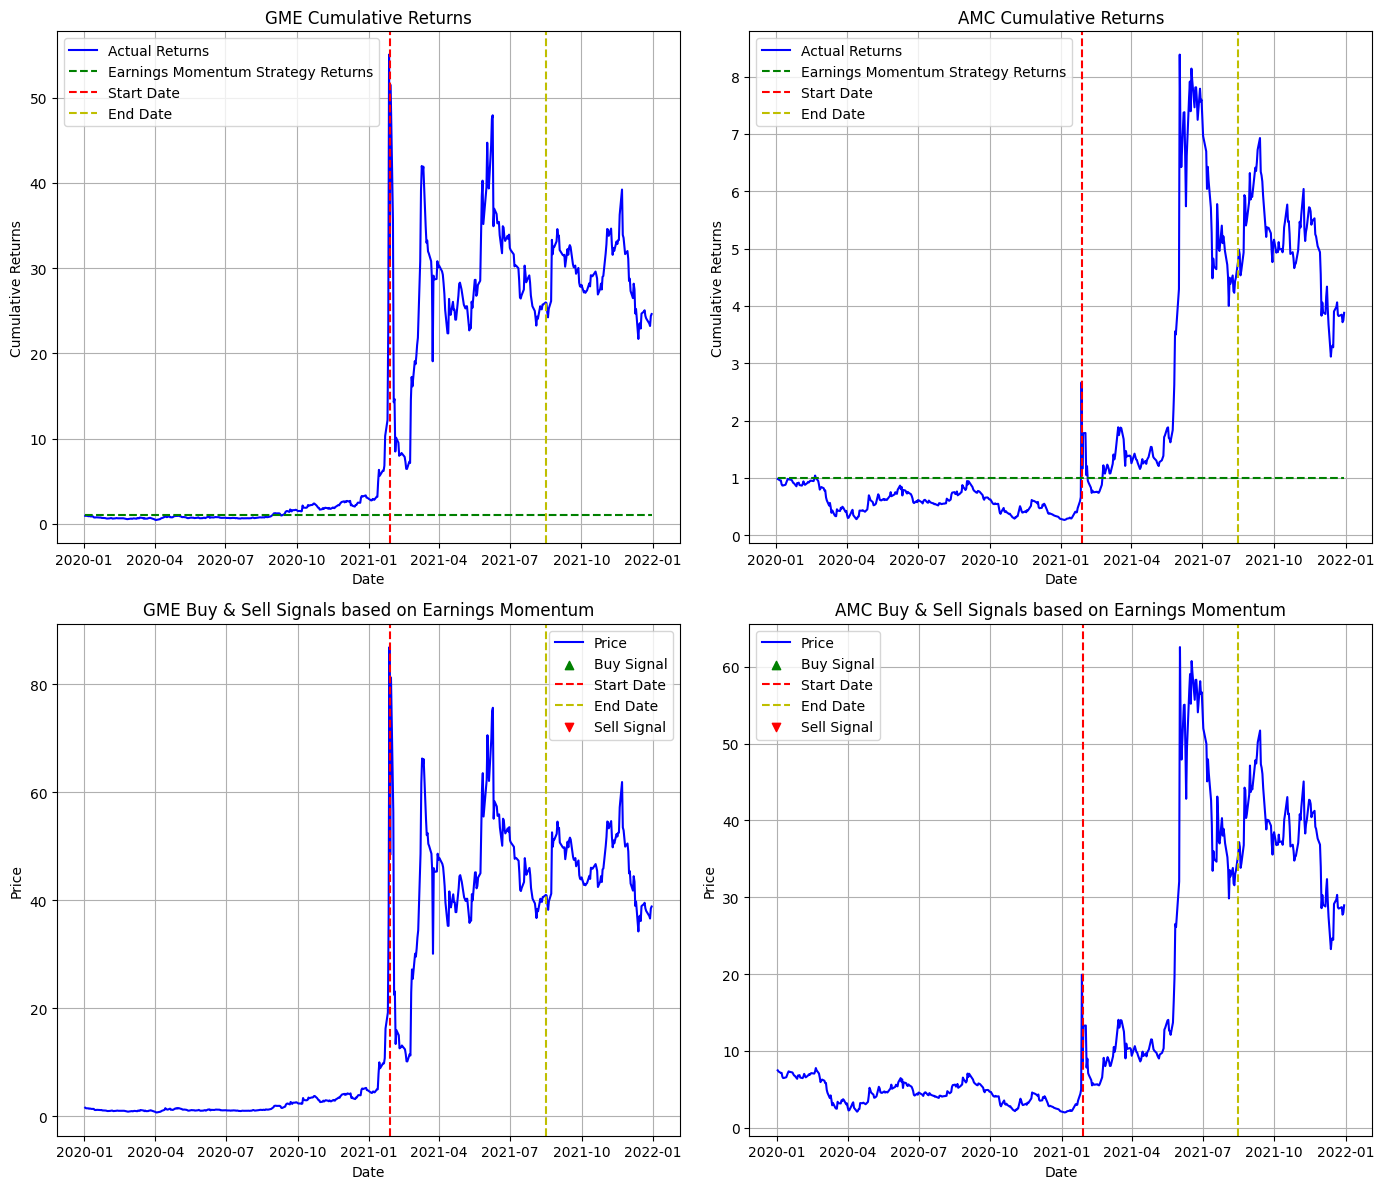

In [29]:
# Compute Earnings Momentum
for symbol in stockList:
    df[('Earnings_Momentum', symbol)] = df[('EPS', symbol)].diff()

for i, symbol in enumerate(stockList, 1):
    # Check if 'Earnings_Momentum' column exists
    if ('Earnings_Momentum', symbol) in df.columns:
        # Buy and sell signals
        df[f'EM_Signal_{symbol}'] = np.where(df[('Earnings_Momentum', symbol)] > 0, 1,  # Buy
                                            np.where(df[('Earnings_Momentum', symbol)] < 0, -1, 0))  # Sell
    else:
        # Print/log the symbols without Earnings_Momentum data for troubleshooting
        print(f"Warning: {symbol} does not have Earnings_Momentum data.")

# ... [Rest of your code]


for i, symbol in enumerate(stockList, 1):
    # Buy and sell signals
    df[f'EM_Signal_{symbol}'] = np.where(df[('Earnings_Momentum', symbol)] > 0, 1, # Buy
                                        np.where(df[('Earnings_Momentum', symbol)] < 0, -1, 0)) # Sell

# Calculate actual cumulative returns
for symbol in stockList:
    df[f'Cumulative_Return_{symbol}'] = (1 + df[('Close', symbol)].pct_change()).cumprod()

plt.figure(figsize=(14, 12))

for i, symbol in enumerate(stockList, 1):
    # Strategy Returns
    df[f'Strategy_Return_{symbol}'] = df[f'EM_Signal_{symbol}'].shift(1) * df[('Close', symbol)].pct_change()
    df[f'Cumulative_Strategy_Return_{symbol}'] = (1 + df[f'Strategy_Return_{symbol}']).cumprod()
    
    # Plot actual vs strategy returns
    plt.subplot(2, 2, i)
    plt.plot(df[f'Cumulative_Return_{symbol}'], label='Actual Returns', color='blue')
    plt.plot(df[f'Cumulative_Strategy_Return_{symbol}'], label='Earnings Momentum Strategy Returns', color='green', linestyle='--')
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    plt.title(f'{symbol} Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)

    # Plot buy and sell signals
    plt.subplot(2, 2, i+2)  # The "+2" positions the plots correctly
    plt.plot(df[('Close', symbol)], label='Price', color='blue')
    plt.scatter(df[df[f'EM_Signal_{symbol}'] == 1].index, df[('Close', symbol)][df[f'EM_Signal_{symbol}'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    plt.scatter(df[df[f'EM_Signal_{symbol}'] == -1].index, df[('Close', symbol)][df[f'EM_Signal_{symbol}'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.title(f'{symbol} Buy & Sell Signals based on Earnings Momentum')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
initial_investment = 1000  # $1000 for each stock

# Earnings Momentum Approach 1
earnings_momentum = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on positive earnings momentum
        if row[('Earnings_Momentum', symbol)] > 0 and not in_position:
            stock_quantity = cash / row[('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on negative earnings momentum
        elif row[('Earnings_Momentum', symbol)] < 0 and in_position:
            cash += stock_quantity * row[('Close', symbol)]
            stock_quantity = 0
            in_position = False

    # Liquidate any remaining stock positions at the end
    if in_position:
        cash += stock_quantity * df[('Close', symbol)].iloc[-1]
        
    earnings_momentum[symbol] = cash - initial_investment

percentage_gains_momentum = {symbol: (earn - initial_investment) / initial_investment * 100 for symbol, earn in earnings_momentum.items()}

print("Earnings Momentum Approach 1 Gain Calculation")
print("--------------------------------------------")
for symbol in stockList:
    print(f"Earnings for {symbol} using Earnings Momentum: ${earnings_momentum[symbol]:.2f}")
    print(f"Percentage gain for {symbol} using Earnings Momentum: {percentage_gains_momentum[symbol]:.2f}%")
    print("--------------------------------------")

# Earnings Momentum Approach 2
print("Earnings Momentum Approach 2 Gain Calculation")
print("--------------------------------------------")

epv_momentum = {}
percentage_gains_momentum_2 = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on positive earnings momentum
        if row[('Earnings_Momentum', symbol)] > 0 and not in_position:
            stock_quantity = cash / row[('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on negative earnings momentum
        elif row[('Earnings_Momentum', symbol)] < 0 and in_position:
            cash += stock_quantity * row[('Close', symbol)]
            stock_quantity = 0
            in_position = False

    # Compute EPV
    epv_momentum[symbol] = cash + (stock_quantity * df[('Close', symbol)].iloc[-1])
    percentage_gains_momentum_2[symbol] = ((epv_momentum[symbol] - initial_investment) / initial_investment) * 100

    print(f"Symbol: {symbol}")
    print(f"Ending Portfolio Value (Earnings Momentum): ${epv_momentum[symbol]:.2f}")
    print(f"Percentage Gain (Earnings Momentum): {percentage_gains_momentum_2[symbol]:.2f}%")
    print("--------------------------------------")


Earnings Momentum Approach 1 Gain Calculation
--------------------------------------------
Earnings for GME using Earnings Momentum: $0.00
Percentage gain for GME using Earnings Momentum: -100.00%
--------------------------------------
Earnings for AMC using Earnings Momentum: $0.00
Percentage gain for AMC using Earnings Momentum: -100.00%
--------------------------------------
Earnings Momentum Approach 2 Gain Calculation
--------------------------------------------
Symbol: GME
Ending Portfolio Value (Earnings Momentum): $1000.00
Percentage Gain (Earnings Momentum): 0.00%
--------------------------------------
Symbol: AMC
Ending Portfolio Value (Earnings Momentum): $1000.00
Percentage Gain (Earnings Momentum): 0.00%
--------------------------------------


## Bollinger Bands Strategy

In [31]:
# Bollinger Bands parameters
n = 10  # Number of days for SMA
k = 2  # Multiplier for standard deviation

for symbol in stockList:
    # Calculate the SMA for the Bollinger Bands
    df['SMA', symbol] = df['Close', symbol].rolling(window=n).mean()
    
    # Calculate the standard deviation for the Bollinger Bands
    df['STD', symbol] = df['Close', symbol].rolling(window=n).std()
    
    # Calculate the upper and lower Bollinger Bands
    df['Upper_Band', symbol] = df['SMA', symbol] + (df['STD', symbol] * k)
    df['Lower_Band', symbol] = df['SMA', symbol] - (df['STD', symbol] * k)
    
    # Generate volatility-based signals (Bollinger Bands)
    df['Volatility_Signal', symbol] = 0  # Default to 0
    df.loc[(df['Close', symbol].shift(1) < df['Lower_Band', symbol].shift(1)) & 
           (df['Close', symbol] > df['Lower_Band', symbol]), ('Volatility_Signal', symbol)] = 1
    df.loc[(df['Close', symbol].shift(1) > df['Upper_Band', symbol].shift(1)) & 
           (df['Close', symbol] < df['Upper_Band', symbol]), ('Volatility_Signal', symbol)] = -1


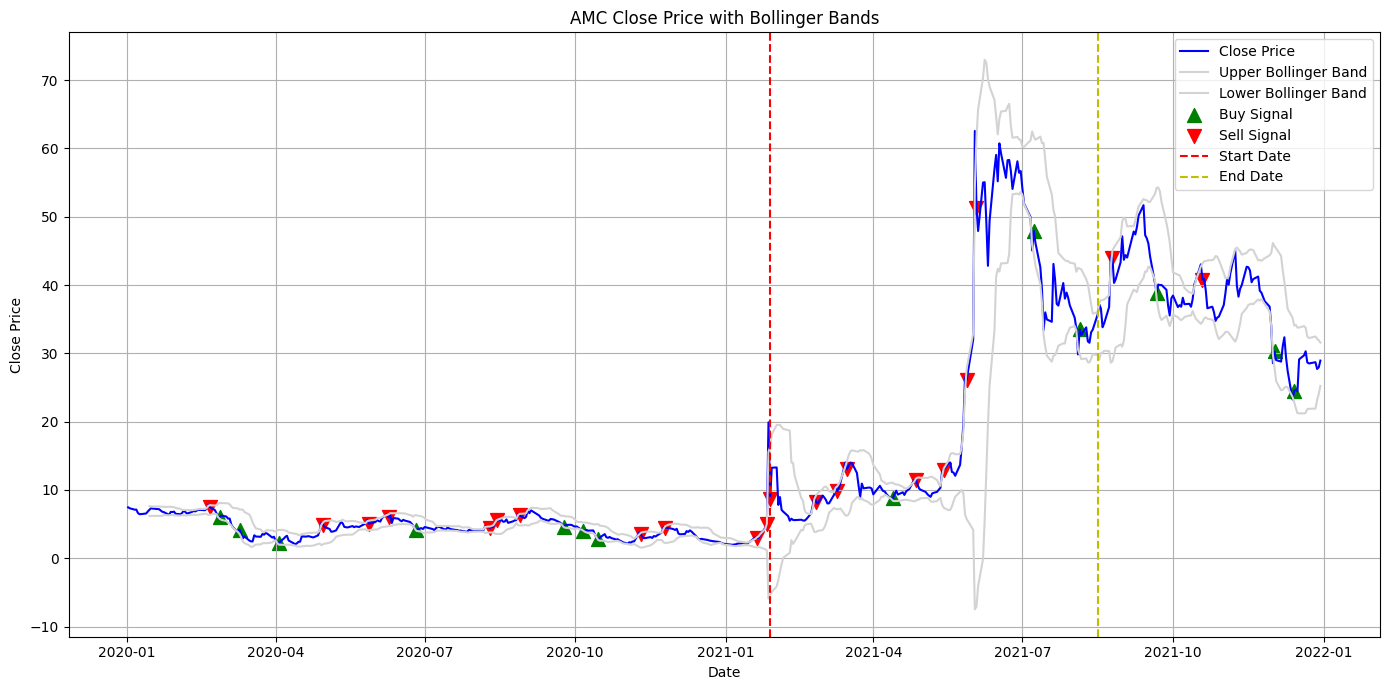

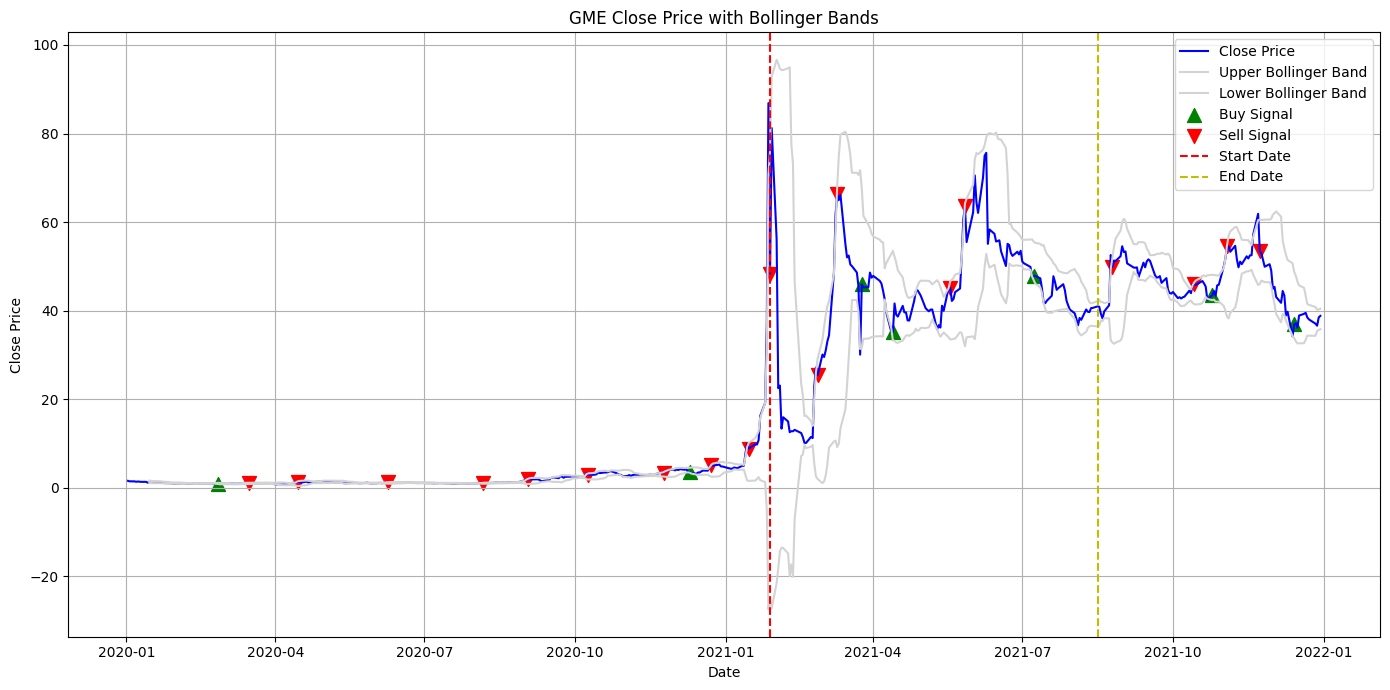

In [32]:
def plot_stock_with_signals(df, symbol):
    plt.figure(figsize=(14, 7))

    # Plot closing price
    plt.plot(df.index, df['Close', symbol], label='Close Price', color='blue')
    
    # Plot Bollinger Bands
    plt.plot(df.index, df['Upper_Band', symbol], label='Upper Bollinger Band', color='lightgray')
    plt.plot(df.index, df['Lower_Band', symbol], label='Lower Bollinger Band', color='lightgray')
    
    # Get indices for buy and sell signals
    buy_signals = df[df['Volatility_Signal', symbol] == 1].index
    sell_signals = df[df['Volatility_Signal', symbol] == -1].index
    
    # Plot buy signals
    plt.scatter(buy_signals, 
                df.loc[buy_signals, ('Close', symbol)], 
                label='Buy Signal', marker='^', alpha=1, color='g', s=100)
    
    # Plot sell signals
    plt.scatter(sell_signals, 
                df.loc[sell_signals, ('Close', symbol)], 
                label='Sell Signal', marker='v', alpha=1, color='r', s=100)
    
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    plt.title(f'{symbol} Close Price with Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for AMC
plot_stock_with_signals(df, 'AMC')

# Plot for GME
plot_stock_with_signals(df, 'GME')


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming stockList and df are defined elsewhere...

initial_investment = 1000  # $1000 for each stock

# Bollinger Bands Approach 1
earnings_bollinger = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on Bollinger Bands
        if row[('Volatility_Signal', symbol)] == 1 and not in_position:
            stock_quantity = cash / row[('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on Bollinger Bands
        elif row[('Volatility_Signal', symbol)] == -1 and in_position:
            cash += stock_quantity * row[('Close', symbol)]
            stock_quantity = 0
            in_position = False

    # Liquidate any remaining stock positions at the end
    if in_position:
        cash += stock_quantity * df[('Close', symbol)].iloc[-1]
        
    earnings_bollinger[symbol] = cash - initial_investment

percentage_gains_bollinger = {symbol: (earn - initial_investment) / initial_investment * 100 for symbol, earn in earnings_bollinger.items()}

print("Bollinger Bands Approach 1 Gain Calculation")
print("------------------------------------------")
for symbol in stockList:
    print(f"Earnings for {symbol} using Bollinger Bands: ${earnings_bollinger[symbol]:.2f}")
    print(f"Percentage gain for {symbol} using Bollinger Bands: {percentage_gains_bollinger[symbol]:.2f}%")
    print("--------------------------------------")

# Bollinger Bands Approach 2
print("Bollinger Bands Approach 2 Gain Calculation")
print("------------------------------------------")

epv_bollinger = {}
percentage_gains_bollinger_2 = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on Bollinger Bands
        if row[('Volatility_Signal', symbol)] == 1 and not in_position:
            stock_quantity = cash / row[('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on Bollinger Bands
        elif row[('Volatility_Signal', symbol)] == -1 and in_position:
            cash += stock_quantity * row[('Close', symbol)]
            stock_quantity = 0
            in_position = False

    # Compute EPV
    epv_bollinger[symbol] = cash + (stock_quantity * df[('Close', symbol)].iloc[-1])
    percentage_gains_bollinger_2[symbol] = ((epv_bollinger[symbol] - initial_investment) / initial_investment) * 100

    print(f"Symbol: {symbol}")
    print(f"Ending Portfolio Value (Bollinger Bands): ${epv_bollinger[symbol]:.2f}")
    print(f"Percentage Gain (Bollinger Bands): {percentage_gains_bollinger_2[symbol]:.2f}%")
    print("--------------------------------------")


Bollinger Bands Approach 1 Gain Calculation
------------------------------------------
Earnings for GME using Bollinger Bands: $1542.47
Percentage gain for GME using Bollinger Bands: 54.25%
--------------------------------------
Earnings for AMC using Bollinger Bands: $-214.54
Percentage gain for AMC using Bollinger Bands: -121.45%
--------------------------------------
Bollinger Bands Approach 2 Gain Calculation
------------------------------------------
Symbol: GME
Ending Portfolio Value (Bollinger Bands): $2542.47
Percentage Gain (Bollinger Bands): 154.25%
--------------------------------------
Symbol: AMC
Ending Portfolio Value (Bollinger Bands): $785.46
Percentage Gain (Bollinger Bands): -21.45%
--------------------------------------


## reddit Sentiment results

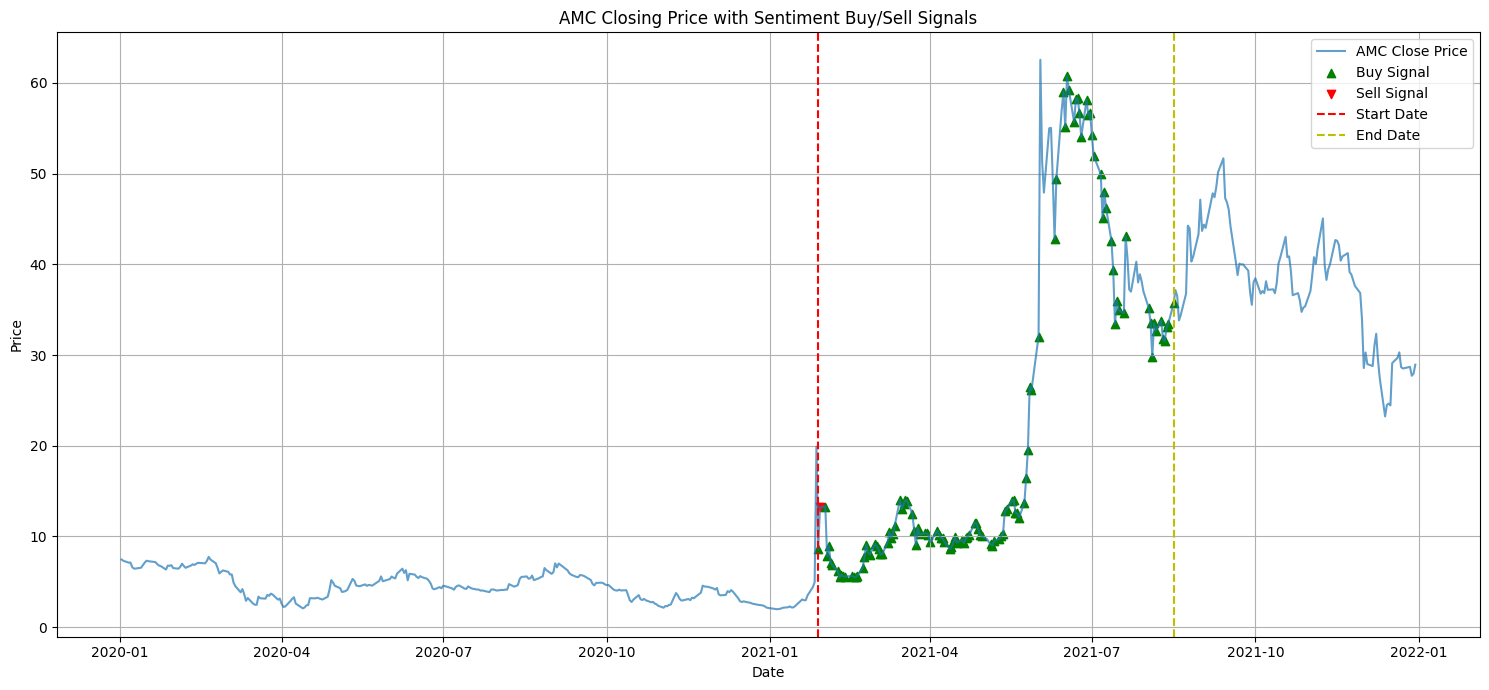

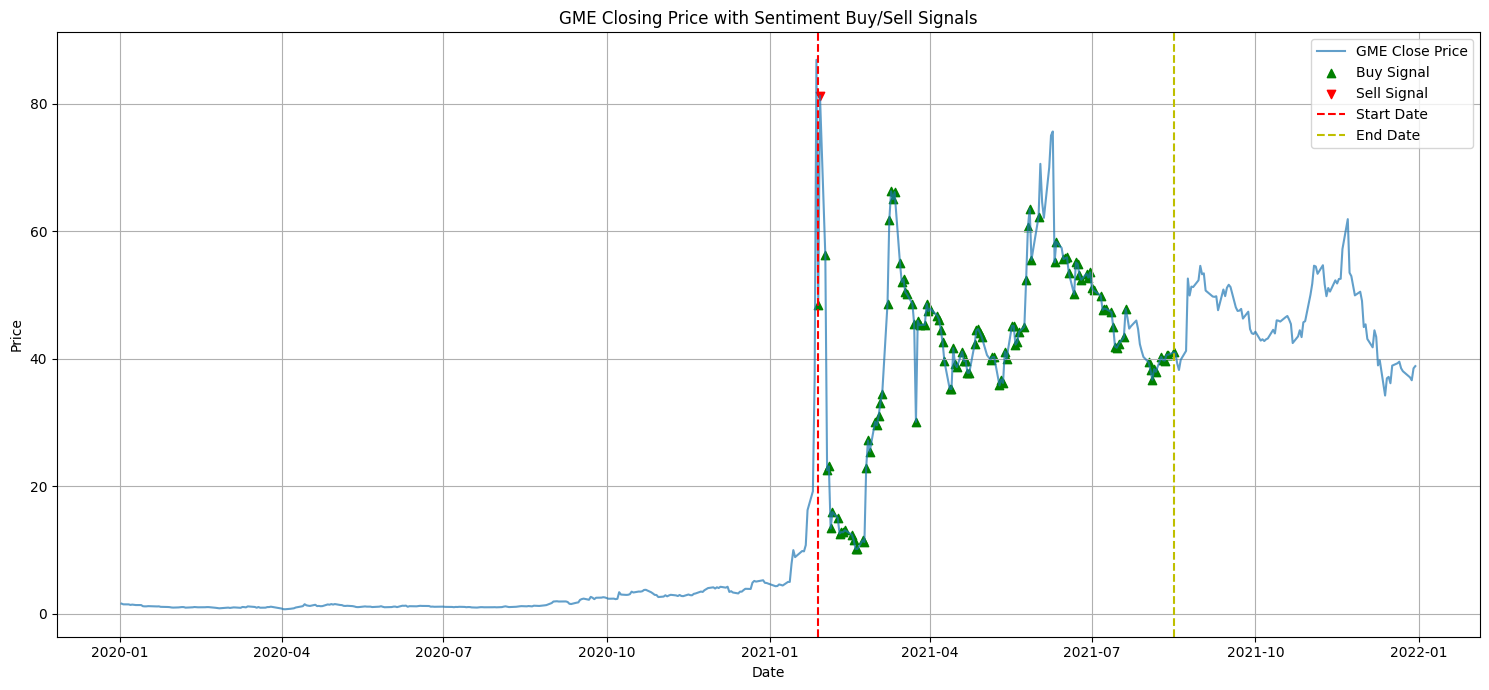

In [34]:
def plot_sentiment_signals(df, symbol):
    plt.figure(figsize=(15, 7))
    
    # Plotting the closing prices
    plt.plot(df.index, df['Close', symbol], label=f'{symbol} Close Price', alpha=0.7)
    
    # Plotting the buy signals
    buys = df[df['sentiment_signal'] == 1]
    plt.scatter(buys.index, df['Close', symbol][buys.index], label='Buy Signal', marker='^', color='g', alpha=1.0)
    
    # Plotting the sell signals
    sells = df[df['sentiment_signal'] == -1]
    plt.scatter(sells.index, df['Close', symbol][sells.index], label='Sell Signal', marker='v', color='r', alpha=1.0)
    
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    plt.title(f'{symbol} Closing Price with Sentiment Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for AMC
plot_sentiment_signals(df, 'AMC')

# Plot for GME
plot_sentiment_signals(df, 'GME')


In [35]:
# Approach 1
initial_investment = 1000  # $1000 for each stock
earnings_sent = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on sentiment
        if row['sentiment_signal'].item() == 1 and not in_position:
            stock_quantity = cash / row[('Close', symbol)]
            cash = 0
            in_position = True

    # Liquidate any remaining stock positions at the end
    if in_position:
        cash += stock_quantity * df[('Close', symbol)].iloc[-1]
        
    earnings_sent[symbol] = cash - initial_investment

percentage_gains_sent = {symbol: (earn - initial_investment) / initial_investment * 100 for symbol, earn in earnings_sent.items()}

print("Sentiment Approach 1 Gain Calculation")
print("------------------------------------")
for symbol in stockList:
    print(f"Earnings for {symbol} using Sentiment: ${earnings_sent[symbol]:.2f}")
    print(f"Percentage gain for {symbol} using Sentiment: {percentage_gains_sent[symbol]:.2f}%")
    print("--------------------------------------")

# Approach 2
print("Sentiment Approach 2 Gain Calculation")
print("------------------------------------")

epv_sent = {}
percentage_gains_sent_2 = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on sentiment
        if row['sentiment_signal'].item() == 1 and not in_position:
            stock_quantity = cash / row[('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on sentiment
        elif row['sentiment_signal'].item() == -1 and in_position:
            cash += stock_quantity * row[('Close', symbol)]
            stock_quantity = 0
            in_position = False
    
    # Compute EPV
    epv_sent[symbol] = cash + (stock_quantity * df[('Close', symbol)].iloc[-1])
    percentage_gains_sent_2[symbol] = ((epv_sent[symbol] - initial_investment) / initial_investment) * 100

    print(f"Symbol: {symbol}")
    print(f"Ending Portfolio Value (Sentiment): ${epv_sent[symbol]:.2f}")
    print(f"Percentage Gain (Sentiment): {percentage_gains_sent_2[symbol]:.2f}%")
    print("--------------------------------------")


Sentiment Approach 1 Gain Calculation
------------------------------------
Earnings for GME using Sentiment: $-197.68
Percentage gain for GME using Sentiment: -119.77%
--------------------------------------
Earnings for AMC using Sentiment: $2353.42
Percentage gain for AMC using Sentiment: 135.34%
--------------------------------------
Sentiment Approach 2 Gain Calculation
------------------------------------
Symbol: GME
Ending Portfolio Value (Sentiment): $1158.91
Percentage Gain (Sentiment): 15.89%
--------------------------------------
Symbol: AMC
Ending Portfolio Value (Sentiment): $3343.33
Percentage Gain (Sentiment): 234.33%
--------------------------------------


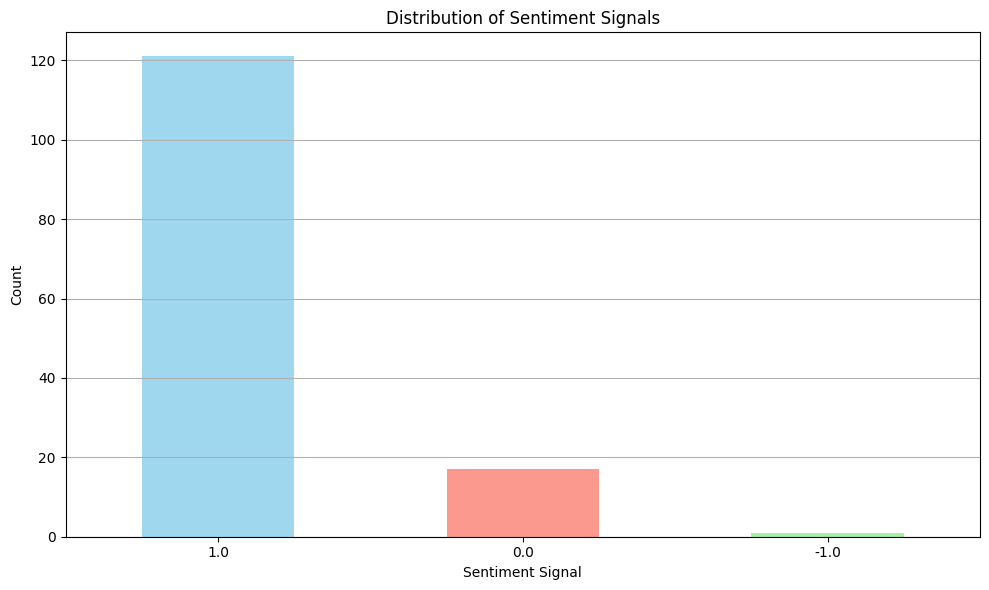

In [36]:
# Count the occurrences of each unique value
sentiment_counts = df['sentiment_signal'].value_counts()

# Generate the bar plot
sentiment_counts.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon', 'lightgreen'], alpha=0.8)

# Setting title and labels
plt.title('Distribution of Sentiment Signals')
plt.xlabel('Sentiment Signal')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()


## Moving Average Crossovers

Choose 2 time periods that give best results.

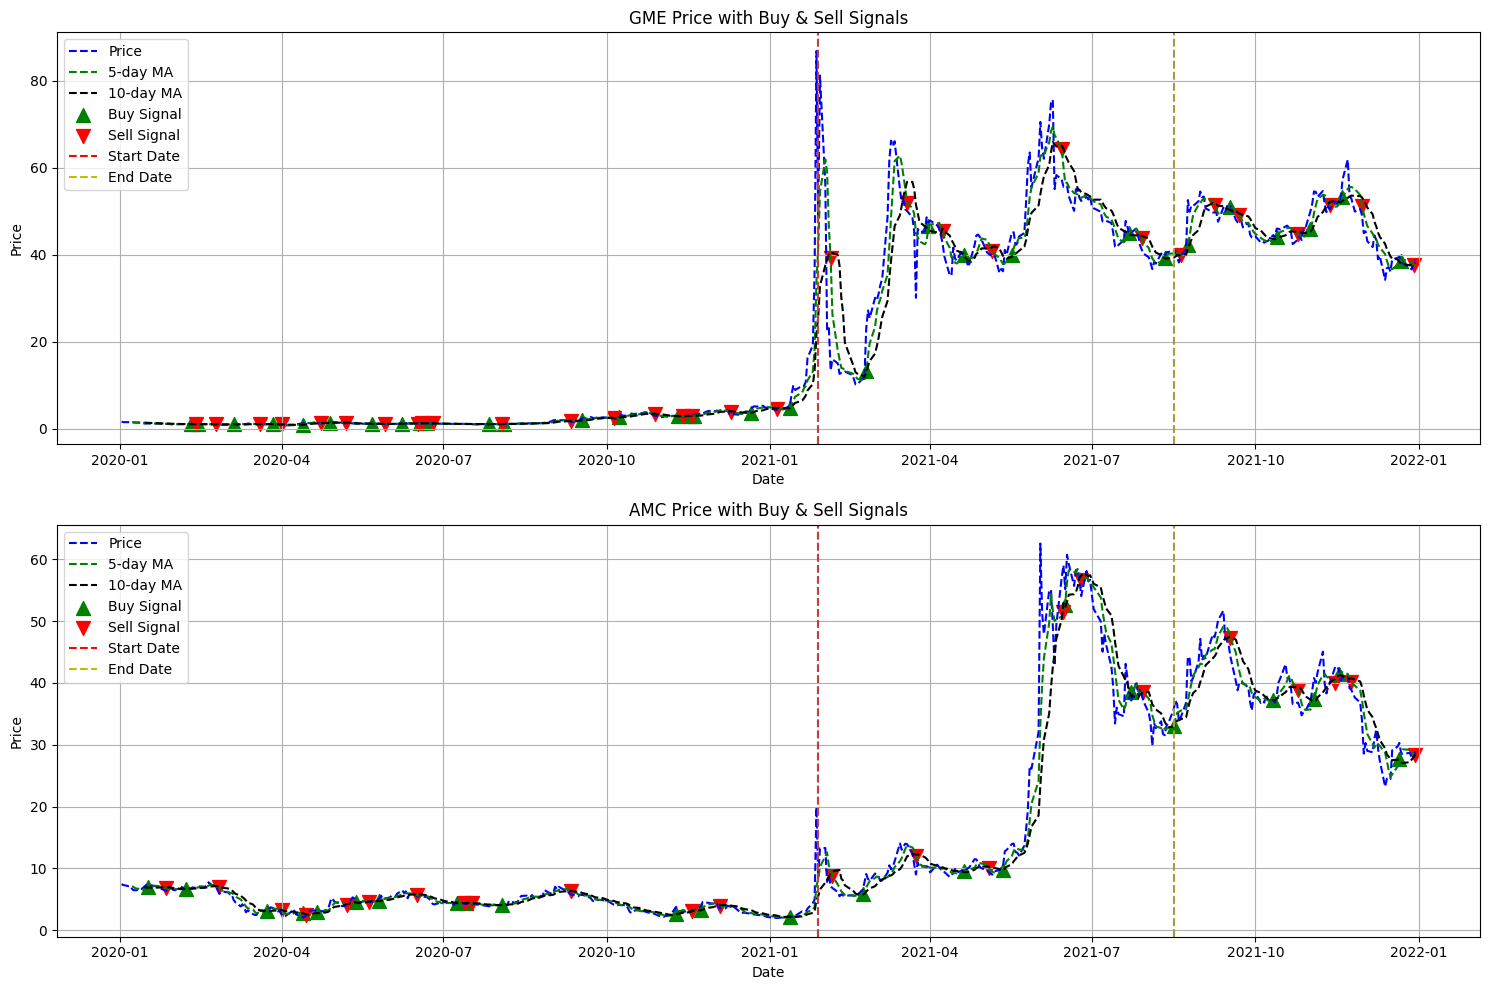

In [37]:
# Calculate the 5-day and 10-day moving averages for each stock
for symbol in stockList:
    df[('5_MA', symbol)] = df[('Close', symbol)].rolling(window=5).mean()
    df[('10_MA', symbol)] = df[('Close', symbol)].rolling(window=10).mean()
    
    # Create a column that holds the difference between the 50-day and 200-day MAs
    # Positive when 50-day MA is above 200-day MA
    df[('MA_Diff', symbol)] = df[('5_MA', symbol)] - df[('10_MA', symbol)]
    
    # Create buy and sell signals
    # Buy when the difference changes from negative to positive
    # Sell when the difference changes from positive to negative
    df[f'MA_Signal_{symbol}'] = np.where(df[('MA_Diff', symbol)].gt(0) & df[('MA_Diff', symbol)].shift(1).lt(0), 1,
                                np.where(df[('MA_Diff', symbol)].lt(0) & df[('MA_Diff', symbol)].shift(1).gt(0), -1, 0))


# Plotting the data along with buy/sell signals
plt.figure(figsize=(15, 10))

marker_size=100
for i, symbol in enumerate(stockList):
    plt.subplot(len(stockList), 1, i+1)  # Change this line to stack plots vertically
    plt.plot(df[('Close', symbol)], label='Price', color='blue',linestyle='--')
    plt.plot(df[('5_MA', symbol)], label='5-day MA', color='green',linestyle='--')
    plt.plot(df[('10_MA', symbol)], label='10-day MA', color='black',linestyle='--')
    plt.scatter(df[df[f'MA_Signal_{symbol}'] == 1].index, df[('5_MA', symbol)][df[f'MA_Signal_{symbol}'] == 1],
                marker='^', color='g', label='Buy Signal', alpha=1,s=marker_size)
    plt.scatter(df[df[f'MA_Signal_{symbol}'] == -1].index, df[('5_MA', symbol)][df[f'MA_Signal_{symbol}'] == -1], 
                marker='v', color='r', label='Sell Signal', alpha=1,s=marker_size)
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    plt.axvline(pd.Timestamp(sent_startDate), color='gray', linestyle='--', alpha=0.5)
    plt.axvline(pd.Timestamp(sent_endDate), color='gray', linestyle='--', alpha=0.5)
    plt.title(f'{symbol} Price with Buy & Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming stockList and df are defined above...

# Approach 1
initial_investment = 1000  # $1000 for each stock
earnings_ma = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on MA crossover
        if df.loc[idx, f'MA_Signal_{symbol}'].item() == 1 and not in_position:
            stock_quantity = cash / df.loc[idx, ('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on MA crossover
        elif df.loc[idx, f'MA_Signal_{symbol}'].item() == -1 and in_position:
            cash = stock_quantity * df.loc[idx, ('Close', symbol)]
            stock_quantity = 0
            in_position = False

    # Liquidate any remaining stock positions at the end
    if in_position:
        cash += stock_quantity * df[('Close', symbol)].iloc[-1]
        
    earnings_ma[symbol] = cash - initial_investment

percentage_gains_ma = {symbol: (earn - initial_investment) / initial_investment * 100 for symbol, earn in earnings_ma.items()}

print("Approach 1 Gain Calculation")
print("----------------------------")
for symbol in stockList:
    print(f"Earnings for {symbol} using MA Crossover: ${earnings_ma[symbol]:.2f}")
    print(f"Percentage gain for {symbol} using MA Crossover: {percentage_gains_ma[symbol]:.2f}%")
    print("--------------------------------------")

# Approach 2
print("Approach 2 Gain Calculation")
print("----------------------------")

epv_ma = {}
percentage_gains_ma_2 = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False  # To check if we are currently holding the stock
    
    for idx, row in df.iterrows():
        # Buy condition based on MA crossover
        if df.loc[idx, f'MA_Signal_{symbol}'].item() == 1 and not in_position:
            stock_quantity = cash / df.loc[idx, ('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on MA crossover
        elif df.loc[idx, f'MA_Signal_{symbol}'].item() == -1 and in_position:
            cash += stock_quantity * df.loc[idx, ('Close', symbol)]
            stock_quantity = 0
            in_position = False
    
    # Compute EPV
    epv_ma[symbol] = cash + (stock_quantity * df[('Close', symbol)].iloc[-1])
    percentage_gains_ma_2[symbol] = ((epv_ma[symbol] - initial_investment) / initial_investment) * 100

    print(f"Symbol: {symbol}")
    print(f"Ending Portfolio Value (MA Crossover): ${epv_ma[symbol]:.2f}")
    print(f"Percentage Gain (MA Crossover): {percentage_gains_ma_2[symbol]:.2f}%")
    print("--------------------------------------")


Approach 1 Gain Calculation
----------------------------
Earnings for GME using MA Crossover: $2611.66
Percentage gain for GME using MA Crossover: 161.17%
--------------------------------------
Earnings for AMC using MA Crossover: $25141.83
Percentage gain for AMC using MA Crossover: 2414.18%
--------------------------------------
Approach 2 Gain Calculation
----------------------------
Symbol: GME
Ending Portfolio Value (MA Crossover): $3611.66
Percentage Gain (MA Crossover): 261.17%
--------------------------------------
Symbol: AMC
Ending Portfolio Value (MA Crossover): $26141.83
Percentage Gain (MA Crossover): 2514.18%
--------------------------------------


## Relative Strength Index (RSI)

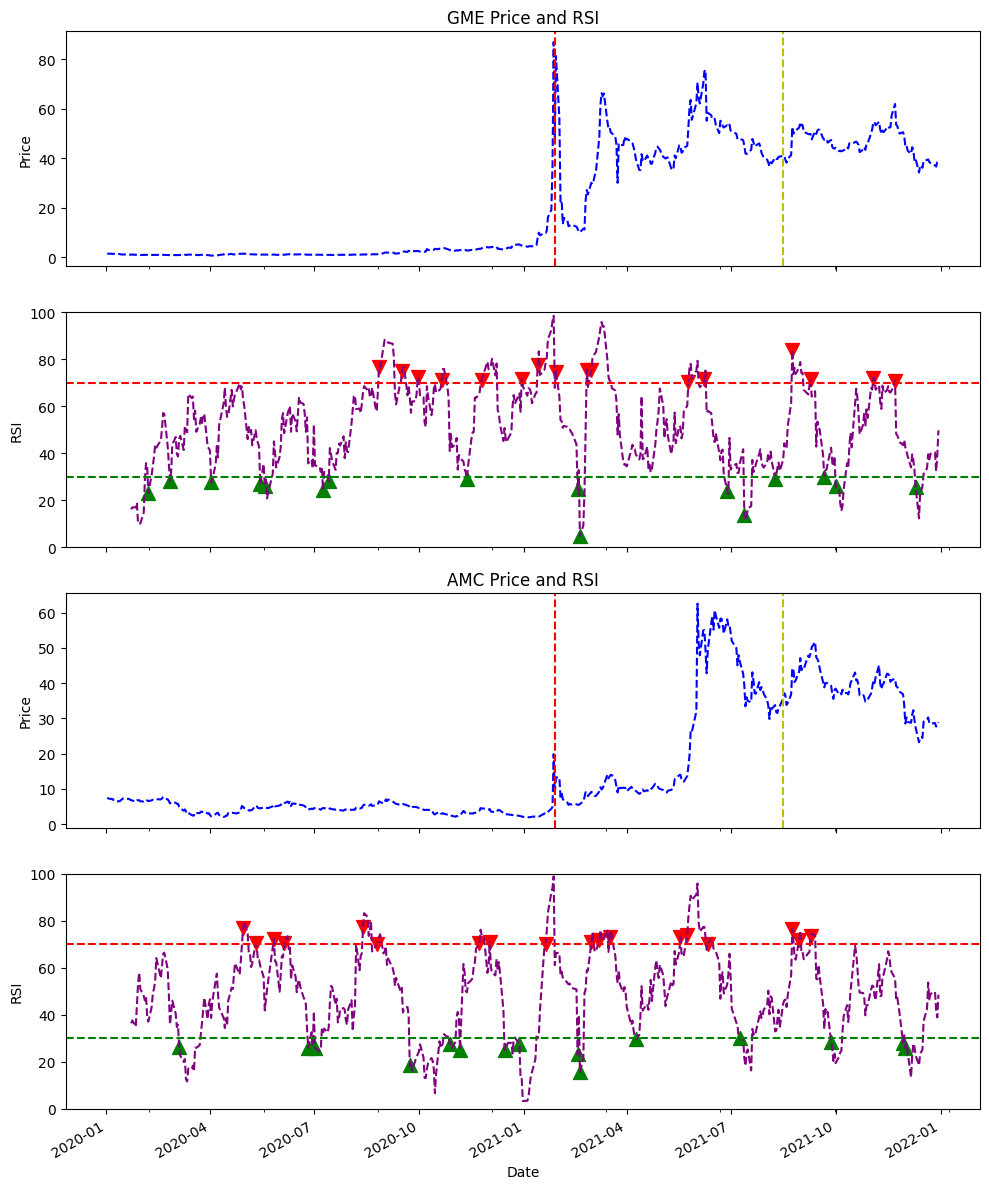

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_rsi(data, window):
    """Compute the Relative Strength Index (RSI) for a series"""
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.abs().rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate the RSI for each stock
window = 14  # Commonly used RSI period
for symbol in stockList:
    df[('RSI', symbol)] = compute_rsi(df[('Close', symbol)], window)
    df[f'RSI_Signal_{symbol}'] = np.where(df[('RSI', symbol)].gt(70) & df[('RSI', symbol)].shift(1).le(70), -1, 
                               np.where(df[('RSI', symbol)].lt(30) & df[('RSI', symbol)].shift(1).ge(30), 1, 0))

# Plotting
plt.figure(figsize=(10, 12))
for i, symbol in enumerate(stockList):
    # Plotting price
    ax1 = plt.subplot(len(stockList)*2, 1, i*2+1)
    df[('Close', symbol)].plot(ax=ax1, color='blue', linestyle='--')
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    ax1.set_ylabel('Price')
    ax1.set_title(f'{symbol} Price and RSI')
    
    # Plotting RSI
    ax2 = plt.subplot(len(stockList)*2, 1, i*2+2, sharex=ax1)
    df[('RSI', symbol)].plot(ax=ax2, color='purple', linestyle='--')
    ax2.axhline(30, color='green', linestyle='--')
    ax2.axhline(70, color='red', linestyle='--')
    
    # Plotting buy and sell signals
    ax2.scatter(df[df[f'RSI_Signal_{symbol}'] == 1].index, df[('RSI', symbol)][df[f'RSI_Signal_{symbol}'] == 1], marker='^', color='g', label='Buy Signal', s=100)
    ax2.scatter(df[df[f'RSI_Signal_{symbol}'] == -1].index, df[('RSI', symbol)][df[f'RSI_Signal_{symbol}'] == -1], marker='v', color='r', label='Sell Signal', s=100)
    ax2.set_ylim([0,100])
    ax2.set_ylabel('RSI')

plt.tight_layout()
plt.show()


In [40]:
# Approach 1 - Gain Calculation using RSI
initial_investment = 1000
earnings_rsi = {}
percentage_gains_rsi = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False

    for idx, row in df.iterrows():
        # Buy condition based on RSI
        if df.loc[idx, f'RSI_Signal_{symbol}'].item() == 1 and not in_position:
            stock_quantity = cash / df.loc[idx, ('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on RSI
        elif df.loc[idx, f'RSI_Signal_{symbol}'].item() == -1 and in_position:
            cash = stock_quantity * df.loc[idx, ('Close', symbol)]
            stock_quantity = 0
            in_position = False

    if in_position:
        cash += stock_quantity * df[('Close', symbol)].iloc[-1]

    earnings_rsi[symbol] = cash - initial_investment
    percentage_gains_rsi[symbol] = (earnings_rsi[symbol] / initial_investment) * 100

print("Approach 1 - Gain Calculation using RSI")
for symbol in stockList:
    print(f"Earnings for {symbol} using RSI: ${earnings_rsi[symbol]:.2f}")
    print(f"Percentage gain for {symbol} using RSI: {percentage_gains_rsi[symbol]:.2f}%")
    print("--------------------------------------")

# Approach 2 - Gain Calculation using RSI
epv_rsi = {}
percentage_gain_rsi = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False

    for idx, row in df.iterrows():
        # Buy condition based on RSI
        if df.loc[idx, f'RSI_Signal_{symbol}'].item() == 1 and not in_position:
            stock_quantity = cash / df.loc[idx, ('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on RSI
        elif df.loc[idx, f'RSI_Signal_{symbol}'].item() == -1 and in_position:
            cash += stock_quantity * df.loc[idx, ('Close', symbol)]
            stock_quantity = 0
            in_position = False

    epv_rsi[symbol] = cash + (stock_quantity * df[('Close', symbol)].iloc[-1])
    percentage_gain_rsi[symbol] = ((epv_rsi[symbol] - initial_investment) / initial_investment) * 100

print("Approach 2 - Gain Calculation using RSI")
for symbol in stockList:
    print(f"Symbol: {symbol}")
    print(f"Ending Portfolio Value using RSI: ${epv_rsi[symbol]:.2f}")
    print(f"Percentage Gain using RSI: {percentage_gain_rsi[symbol]:.2f}%")
    print("--------------------------------------")


Approach 1 - Gain Calculation using RSI
Earnings for GME using RSI: $3785.47
Percentage gain for GME using RSI: 378.55%
--------------------------------------
Earnings for AMC using RSI: $827.81
Percentage gain for AMC using RSI: 82.78%
--------------------------------------
Approach 2 - Gain Calculation using RSI
Symbol: GME
Ending Portfolio Value using RSI: $4785.47
Percentage Gain using RSI: 378.55%
--------------------------------------
Symbol: AMC
Ending Portfolio Value using RSI: $1827.81
Percentage Gain using RSI: 82.78%
--------------------------------------


## MACD (Moving Average Convergence Divergence):

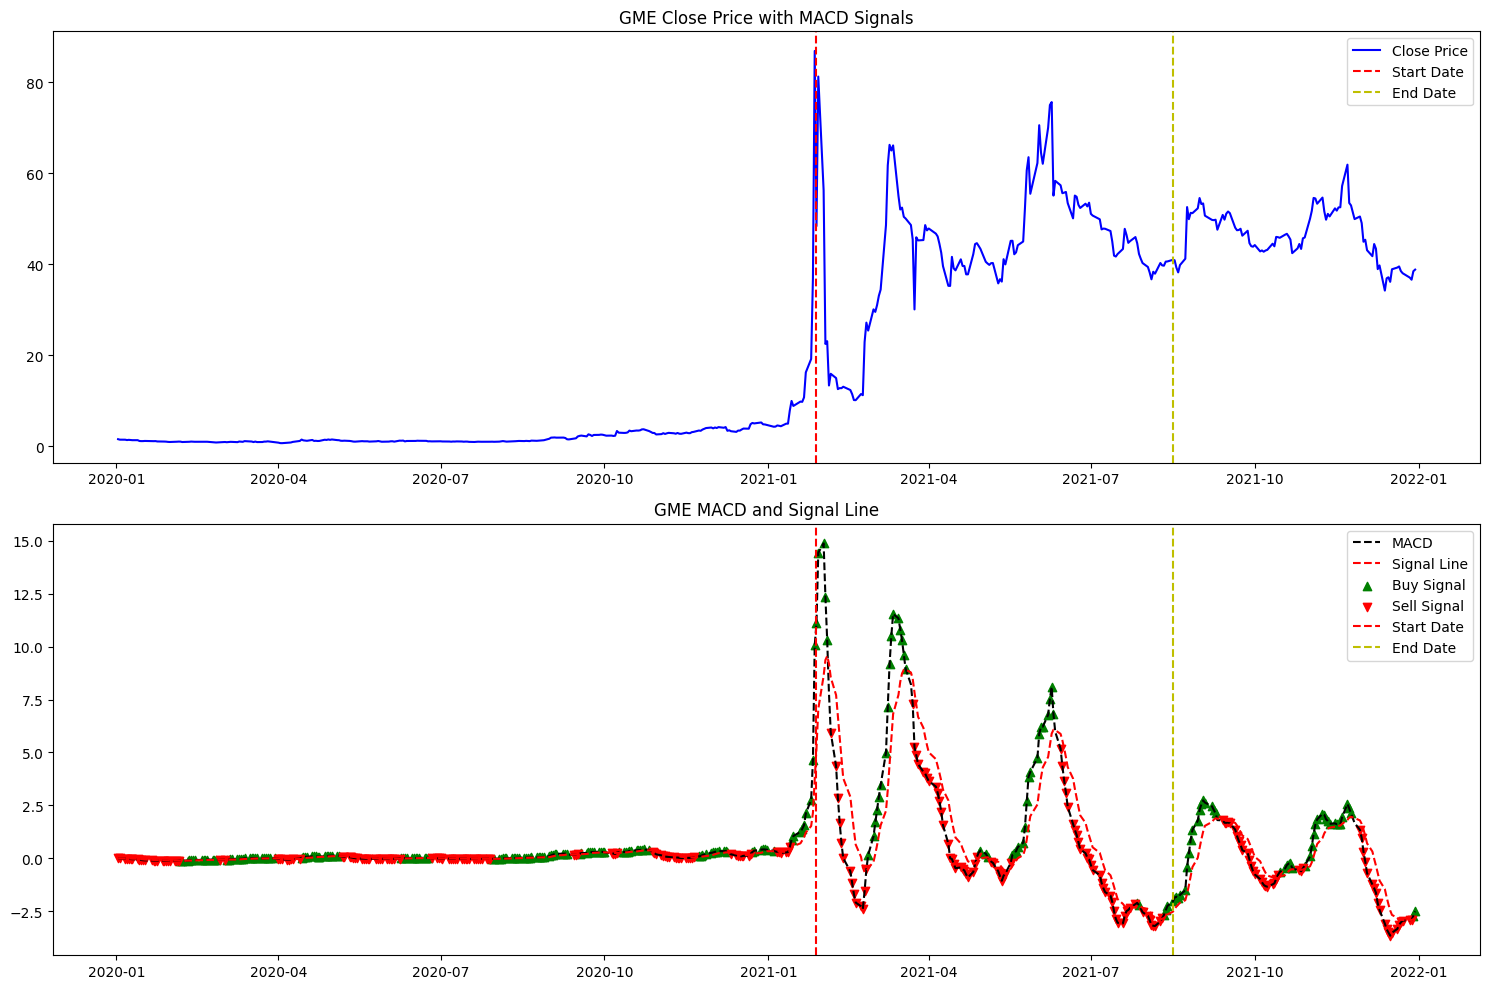

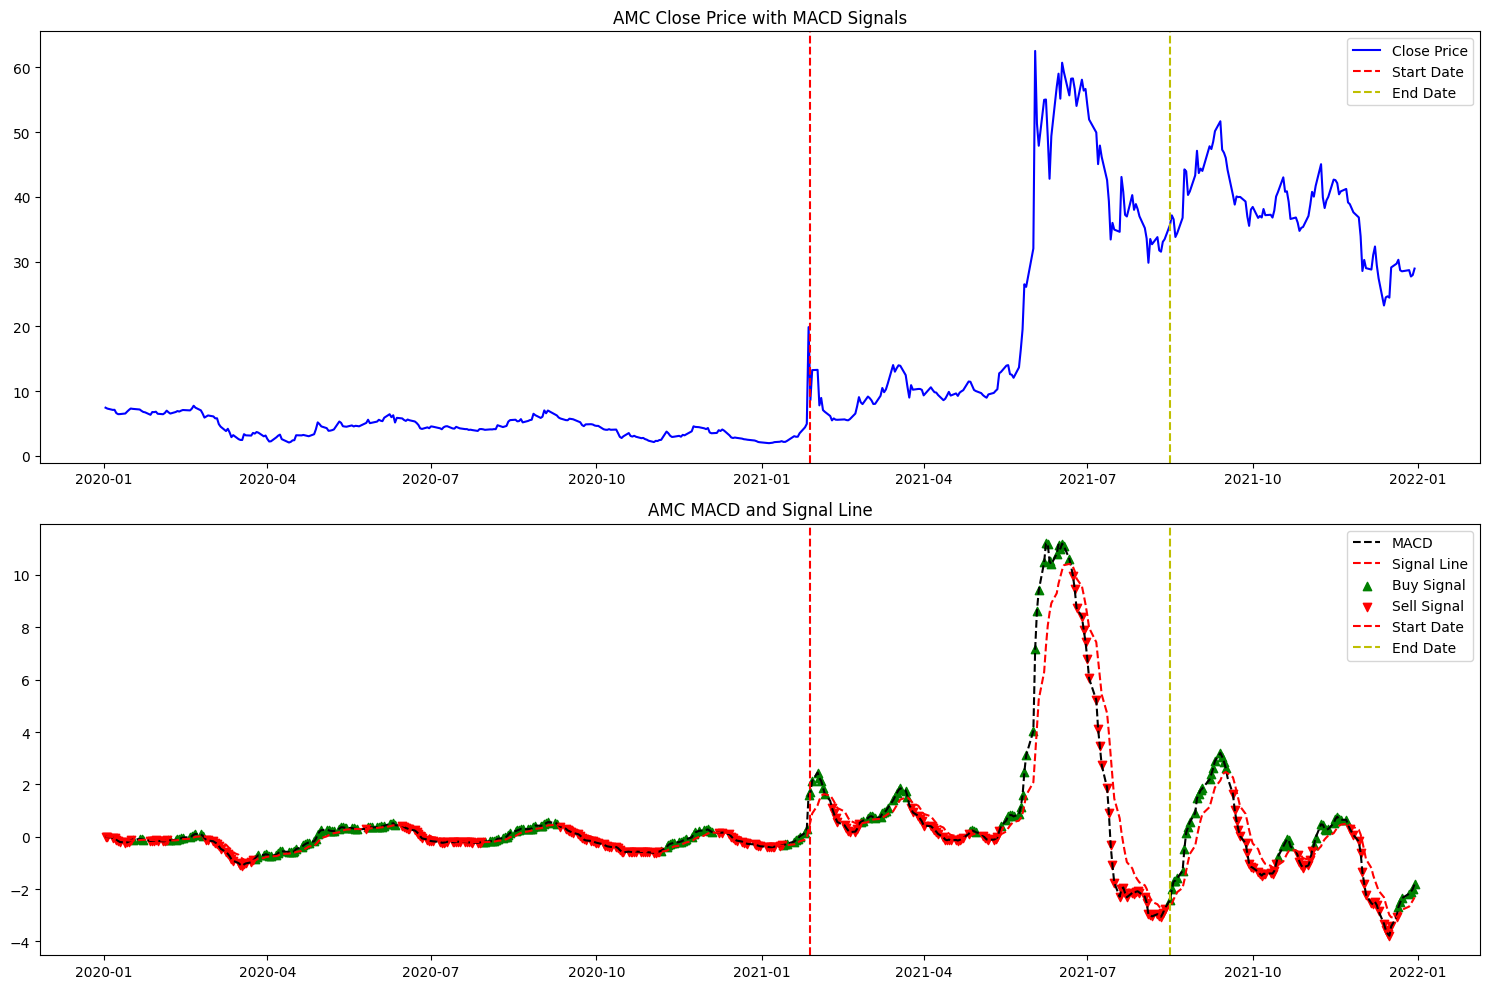

In [41]:
# Calculate the MACD and Signal Line indicators
for symbol in stockList:
    # Calculate the Short Term (12 days) EMA of Close Price
    df[('Short_EMA', symbol)] = df[('Close', symbol)].ewm(span=12, adjust=False).mean()
    
    # Calculate the Long Term (26 days) EMA of Close Price
    df[('Long_EMA', symbol)] = df[('Close', symbol)].ewm(span=26, adjust=False).mean()
    
    # Calculate the MACD Line
    df[('MACD', symbol)] = df[('Short_EMA', symbol)] - df[('Long_EMA', symbol)]
    
    # Calculate the Signal Line
    df[('Signal_Line', symbol)] = df[('MACD', symbol)].ewm(span=9, adjust=False).mean()

    # Define Buy/Sell signals
    df[f'MACD_Signal_{symbol}'] = np.where(df[('MACD', symbol)] > df[('Signal_Line', symbol)], 1, 0)
    df[f'MACD_Signal_{symbol}'] = np.where(df[('MACD', symbol)].shift(1) > df[('Signal_Line', symbol)].shift(1), df[f'MACD_Signal_{symbol}'], -1)

# Plot
for symbol in stockList:
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df[('Close', symbol)], label='Close Price', color='blue')
    plt.title(f'{symbol} Close Price with MACD Signals')
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(df[('MACD', symbol)], label='MACD', color='black', linestyle='--')
    plt.plot(df[('Signal_Line', symbol)], label='Signal Line', color='red', linestyle='--')
    plt.scatter(df[df[f'MACD_Signal_{symbol}'] == 1].index, df[('MACD', symbol)][df[f'MACD_Signal_{symbol}'] == 1],
                marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(df[df[f'MACD_Signal_{symbol}'] == -1].index, df[('MACD', symbol)][df[f'MACD_Signal_{symbol}'] == -1],
                marker='v', color='r', label='Sell Signal', alpha=1)
    plt.axvline(pd.Timestamp(sent_startDate), color='r', linestyle='--', label='Start Date')
    plt.axvline(pd.Timestamp(sent_endDate), color='y', linestyle='--', label='End Date')
    plt.title(f'{symbol} MACD and Signal Line')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [42]:
# Approach 1 - Gain Calculation using MACD
initial_investment = 1000
earnings_macd = {}
percentage_gains_macd = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False
    
    for idx, row in df.iterrows():
        # Buy condition based on MACD crossover
        if (df.loc[idx, f'MACD_Signal_{symbol}'] == 1).item() and not in_position:
            stock_quantity = cash / df.loc[idx, ('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on MACD crossover
        elif (df.loc[idx, f'MACD_Signal_{symbol}'] == -1).item() and in_position:
            cash = stock_quantity * df.loc[idx, ('Close', symbol)]
            stock_quantity = 0
            in_position = False
    
    if in_position:
        cash += stock_quantity * df[('Close', symbol)].iloc[-1]
        
    earnings_macd[symbol] = cash - initial_investment
    percentage_gains_macd[symbol] = (earnings_macd[symbol] / initial_investment) * 100

print("Approach 1 - Gain Calculation using MACD")
for symbol in stockList:
    print(f"Earnings for {symbol} using MACD: ${earnings_macd[symbol]:.2f}")
    print(f"Percentage gain for {symbol} using MACD: {percentage_gains_macd[symbol]:.2f}%")
    print("--------------------------------------")

# Approach 2 - Gain Calculation using MACD
epv_macd = {}
percentage_gain_macd = {}

for symbol in stockList:
    cash = initial_investment
    stock_quantity = 0
    in_position = False
    
    for idx, row in df.iterrows():
        # Buy condition based on MACD crossover
        if (df.loc[idx, f'MACD_Signal_{symbol}'] == 1).item() and not in_position:
            stock_quantity = cash / df.loc[idx, ('Close', symbol)]
            cash = 0
            in_position = True
        # Sell condition based on MACD crossover
        elif (df.loc[idx, f'MACD_Signal_{symbol}'] == -1).item() and in_position:
            cash += stock_quantity * df.loc[idx, ('Close', symbol)]
            stock_quantity = 0
            in_position = False
    
    epv_macd[symbol] = cash + (stock_quantity * df[('Close', symbol)].iloc[-1])
    percentage_gain_macd[symbol] = ((epv_macd[symbol] - initial_investment) / initial_investment) * 100

print("Approach 2 - Gain Calculation using MACD")
for symbol in stockList:
    print(f"Symbol: {symbol}")
    print(f"Ending Portfolio Value using MACD: ${epv_macd[symbol]:.2f}")
    print(f"Percentage Gain using MACD: {percentage_gain_macd[symbol]:.2f}%")
    print("--------------------------------------")


Approach 1 - Gain Calculation using MACD
Earnings for GME using MACD: $2359.78
Percentage gain for GME using MACD: 235.98%
--------------------------------------
Earnings for AMC using MACD: $29743.92
Percentage gain for AMC using MACD: 2974.39%
--------------------------------------
Approach 2 - Gain Calculation using MACD
Symbol: GME
Ending Portfolio Value using MACD: $3359.78
Percentage Gain using MACD: 235.98%
--------------------------------------
Symbol: AMC
Ending Portfolio Value using MACD: $30743.92
Percentage Gain using MACD: 2974.39%
--------------------------------------


## Results Summary

### Approach One 

In [43]:
# approach one outputs

first_aproach_earnings = [earnings_PM, earnings_momentum, earnings_bollinger, earnings_sent, 
                 earnings_ma, earnings_rsi, earnings_macd]

first_aproach_Percentage_gains = [percentage_gains_PM, percentage_gains_momentum,
                 percentage_gains_bollinger, percentage_gains_sent, percentage_gains_ma, 
                percentage_gains_rsi, percentage_gains_macd]

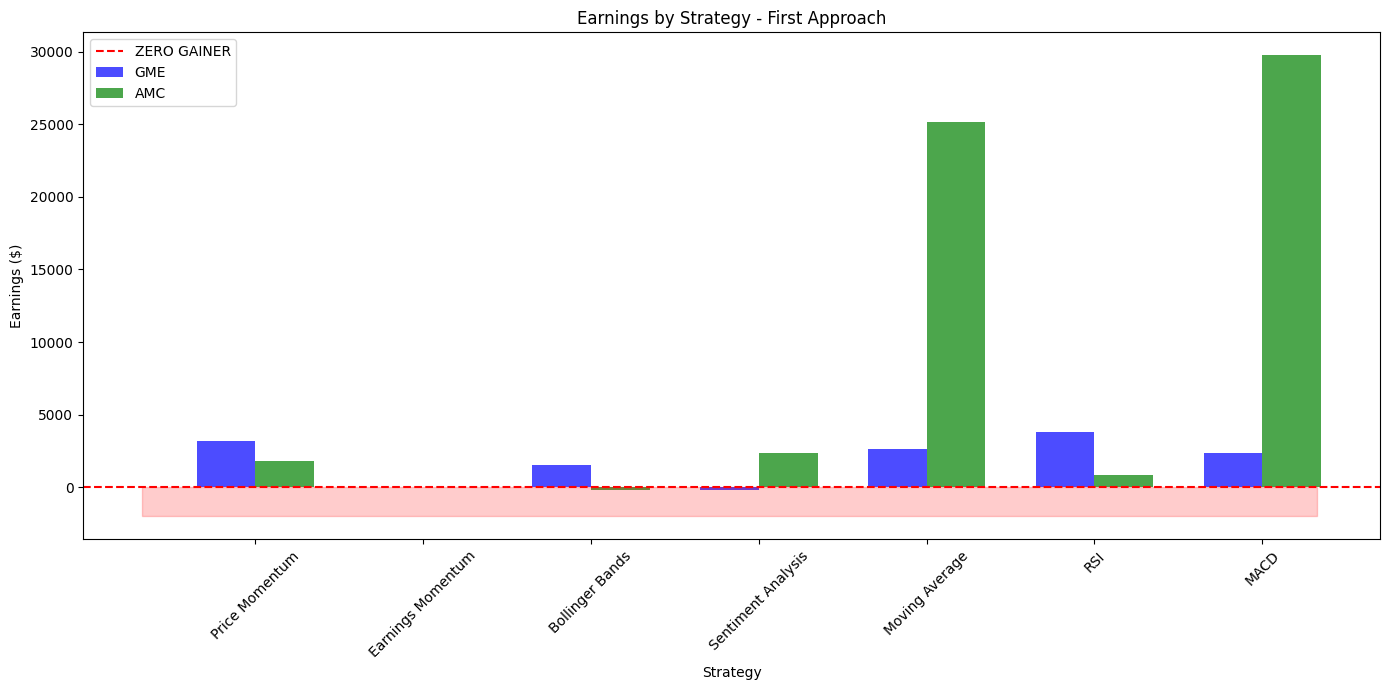

In [44]:
import matplotlib.pyplot as plt

# Calculate average earnings for each strategy
avg_earnings_GME = [d['GME'] for d in first_aproach_earnings]
avg_earnings_AMC = [d['AMC'] for d in first_aproach_earnings]

# List of strategies
strategies = ['Price Momentum', 'Earnings Momentum', 'Bollinger Bands', 'Sentiment Analysis', 
              'Moving Average', 'RSI', 'MACD']

# Plotting the earnings for GME and AMC
plt.figure(figsize=(14, 7))

bar_width = 0.35
index = range(len(strategies))

bar1 = plt.bar(index, avg_earnings_GME, bar_width, label='GME', color='blue', alpha=0.7)
bar2 = plt.bar([i+bar_width for i in index], avg_earnings_AMC, bar_width, label='AMC', color='green', alpha=0.7)

plt.axhline(y=0, color='r', linestyle='--', label=f'ZERO GAINER')
# Fill the area below zero with red color
plt.fill_between([-0.5, len(strategies)-0.5], -2000, 0, color='red', alpha=0.2) 

plt.xlabel('Strategy')
plt.ylabel('Earnings ($)')
plt.title('Earnings by Strategy - First Approach')
plt.xticks([i+bar_width/2 for i in index], strategies, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


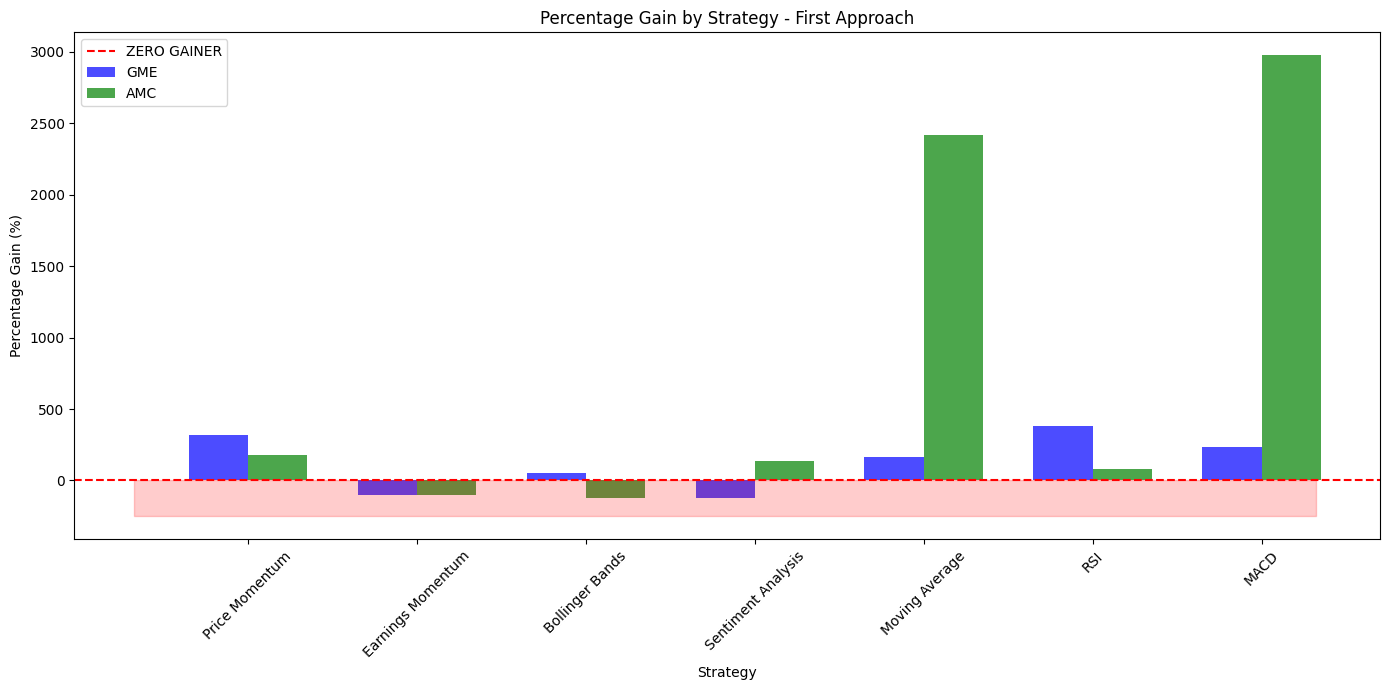

In [45]:
# Calculate average percentage gains for each strategy
avg_percentage_gains_GME = [d['GME'] for d in first_aproach_Percentage_gains]
avg_percentage_gains_AMC = [d['AMC'] for d in first_aproach_Percentage_gains]

# List of strategies
strategies = ['Price Momentum', 'Earnings Momentum', 'Bollinger Bands', 'Sentiment Analysis', 
              'Moving Average', 'RSI', 'MACD']

# Plotting the percentage gains for GME and AMC
plt.figure(figsize=(14, 7))

bar_width = 0.35
index = range(len(strategies))

bar1 = plt.bar(index, avg_percentage_gains_GME, bar_width, label='GME', color='blue', alpha=0.7)
bar2 = plt.bar([i+bar_width for i in index], avg_percentage_gains_AMC, bar_width, label='AMC', color='green', alpha=0.7)

plt.axhline(y=0, color='r', linestyle='--', label=f'ZERO GAINER')

# Fill the area below zero with red color, covering the full width
plt.fill_between([-0.5, len(strategies)-0.5], -250, 0, color='red', alpha=0.2)  

plt.xlabel('Strategy')
plt.ylabel('Percentage Gain (%)')
plt.title('Percentage Gain by Strategy - First Approach')
plt.xticks([i+bar_width/2 for i in index], strategies, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Approach Two

In [46]:
# approach Two outputs
 
second_aproach_earnings = [epv_PM, epv_momentum, epv_bollinger, epv_sent, 
                 epv_ma, epv_rsi, epv_macd]

second_aproach_Percentage_gains = [percentage_gains_PM_2, percentage_gains_momentum_2,
                 percentage_gains_bollinger_2, percentage_gains_sent_2, percentage_gains_ma_2, 
                percentage_gain_rsi, percentage_gain_macd]

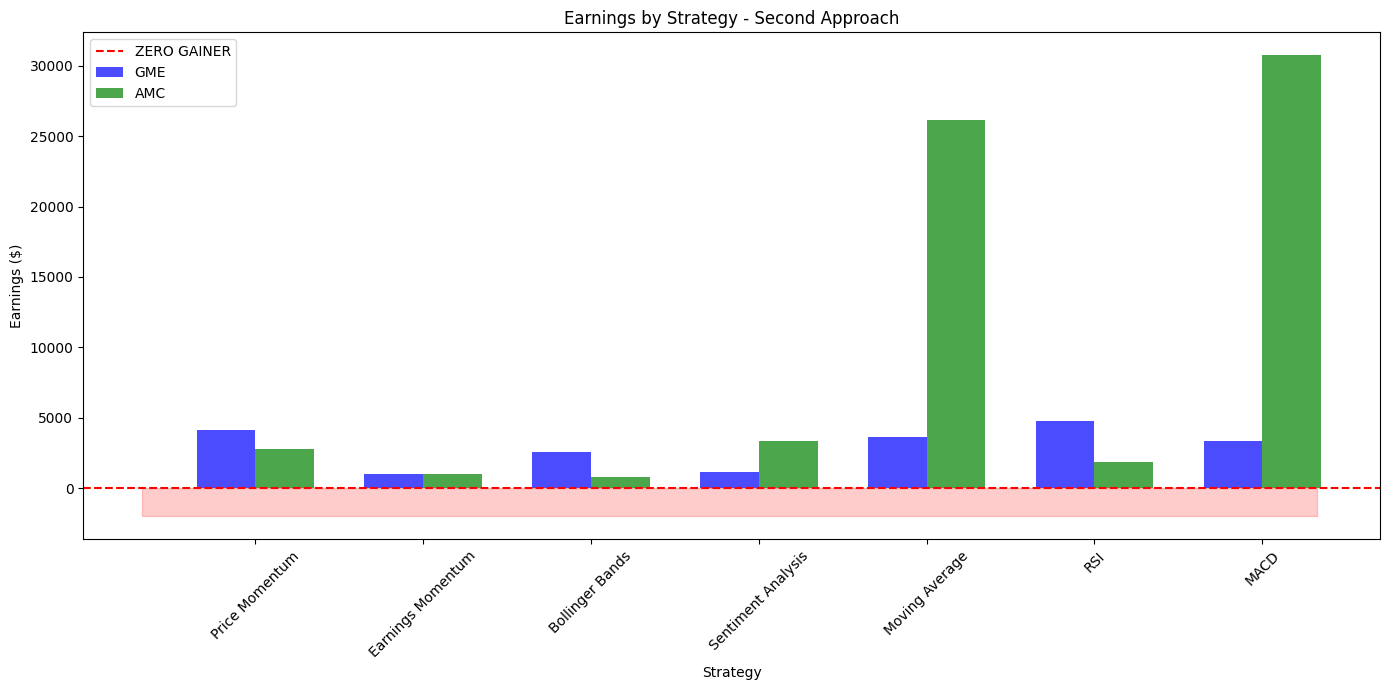

In [47]:
import matplotlib.pyplot as plt

# Calculate average earnings for each strategy
avg_earnings_GME = [d['GME'] for d in second_aproach_earnings]
avg_earnings_AMC = [d['AMC'] for d in second_aproach_earnings]

# List of strategies
strategies = ['Price Momentum', 'Earnings Momentum', 'Bollinger Bands', 'Sentiment Analysis', 
              'Moving Average', 'RSI', 'MACD']

# Plotting the earnings for GME and AMC
plt.figure(figsize=(14, 7))

bar_width = 0.35
index = range(len(strategies))

bar1 = plt.bar(index, avg_earnings_GME, bar_width, label='GME', color='blue', alpha=0.7)
bar2 = plt.bar([i+bar_width for i in index], avg_earnings_AMC, bar_width, label='AMC', color='green', alpha=0.7)

plt.axhline(y=0, color='r', linestyle='--', label=f'ZERO GAINER')
# Fill the area below zero with red color
plt.fill_between([-0.5, len(strategies)-0.5], -2000, 0, color='red', alpha=0.2) 

plt.xlabel('Strategy')
plt.ylabel('Earnings ($)')
plt.title('Earnings by Strategy - Second Approach')
plt.xticks([i+bar_width/2 for i in index], strategies, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


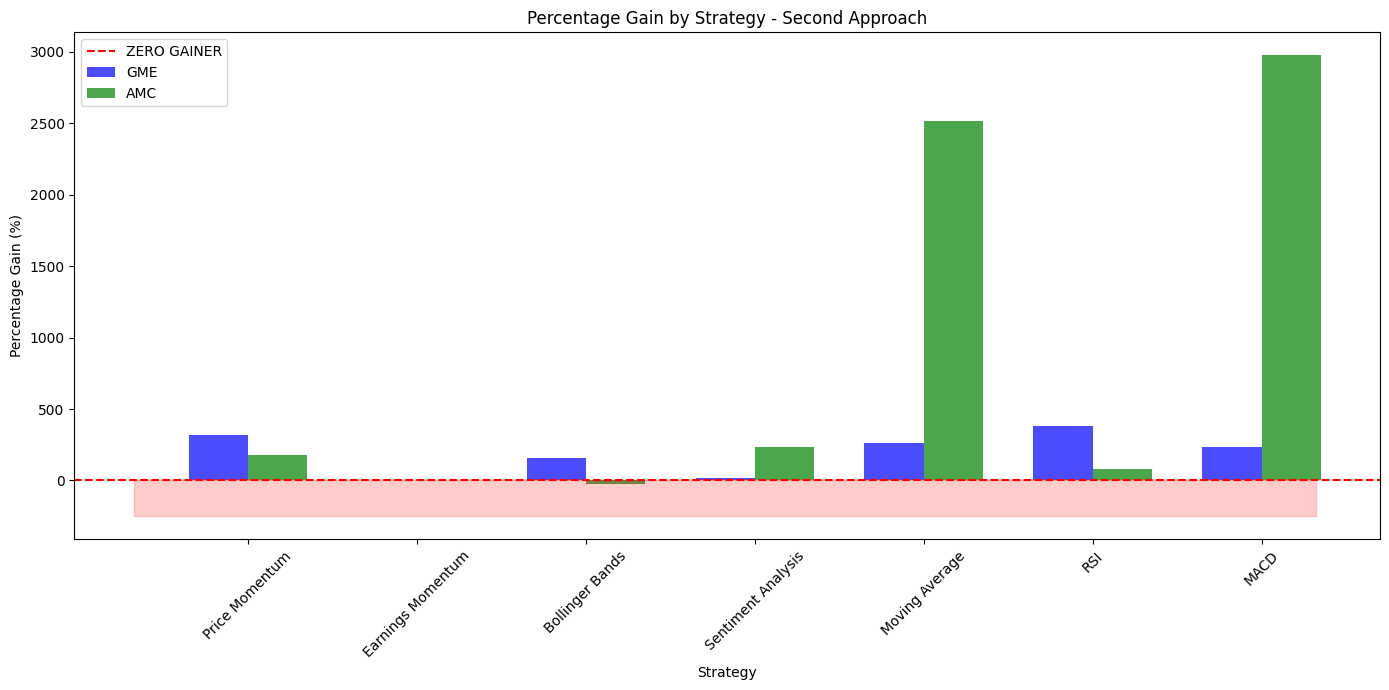

In [48]:
# Calculate average percentage gains for each strategy
avg_percentage_gains_GME = [d['GME'] for d in second_aproach_Percentage_gains]
avg_percentage_gains_AMC = [d['AMC'] for d in second_aproach_Percentage_gains]

# List of strategies
strategies = ['Price Momentum', 'Earnings Momentum', 'Bollinger Bands', 'Sentiment Analysis', 
              'Moving Average', 'RSI', 'MACD']

# Plotting the percentage gains for GME and AMC
plt.figure(figsize=(14, 7))

bar_width = 0.35
index = range(len(strategies))

bar1 = plt.bar(index, avg_percentage_gains_GME, bar_width, label='GME', color='blue', alpha=0.7)
bar2 = plt.bar([i+bar_width for i in index], avg_percentage_gains_AMC, bar_width, label='AMC', color='green', alpha=0.7)

plt.axhline(y=0, color='r', linestyle='--', label=f'ZERO GAINER')

# Fill the area below zero with red color, covering the full width
plt.fill_between([-0.5, len(strategies)-0.5], -250, 0, color='red', alpha=0.2)  

plt.xlabel('Strategy')
plt.ylabel('Percentage Gain (%)')
plt.title('Percentage Gain by Strategy - Second Approach')
plt.xticks([i+bar_width/2 for i in index], strategies, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
